### imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List, Any, Callable
from pandas.core.frame import DataFrame

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")


### Constants

In [2]:
caminhos = {
    'dengue_path': 'dengue.csv',
    'distritos_path': 'distritos.xls',
    'atributos_path': 'attributes.csv'
}

nan_list = [None, [], {}, 'NaN', 'Null','NULL','None', 'none', 'NA','<NA>','NaT','?','-', '.','', ' ', '   ']


data_columns = [
 'CS_ESCOL_N',
 'CS_RACA',
 'CS_SEXO',
 'DT_NASC',
 'DT_NOTIFIC',
 'DT_OBITO',
     'ID_AGRAVO',
 'ID_MN_RESI',
 'ID_MUNICIP',
 'ID_REGIONA',
     'MUNICIPIO',
     'NU_ANO',
     'SG_UF',
 'SG_UF_NOT',
    'UF' ]


regioes = {
    'Norte': ['Acre', 'Amapá', 'Amazonas', 'Pará', 'Rondônia', 'Roraima', 'Tocantins'],
    'Nordeste': ['Alagoas', 'Bahia', 'Ceará', 'Maranhão', 'Paraíba', 'Pernambuco', 'Piauí', 'Rio Grande do Norte', 'Sergipe'],
    'Centro-Oeste': ['Goiás', 'Mato Grosso', 'Mato Grosso do Sul', 'Distrito Federal'],
    'Sudeste': ['Espírito Santo', 'Minas Gerais', 'Rio de Janeiro', 'São Paulo'],
    'Sul': ['Paraná', 'Rio Grande do Sul', 'Santa Catarina']
}

colunas = ['idade', 'ano', 'mes', 'estado', 'municipio', 'genero', 'obito']

cores_obito = {0: 'lightseagreen', 1: 'indianred'}

### Utils

In [3]:
def encontrar_regiao(estado) -> None:
    
    for regiao, estados in regioes.items():
        if estado in estados:
            return regiao
        
    return None

def determinar_grupo_idade(idade):
    
    """
    Retorna o grupo de idade baseado no valor fornecido.
    
    Parâmetros:
    - idade (int): A idade da pessoa.
    
    Retorna:
    - str: O grupo de idade correspondente.
    """
    
    if idade <= 12:
        return 'Crianças'
    elif idade <= 19:
        return 'Jovens'
    elif idade <= 59:
        return 'Adultos'
    else:
        return 'Idosos'


### Load Data

In [5]:
def carregar_dados(dengue_path: str, distritos_path: str, atributos_path: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    """
    Carrega e processa os dados de dengue, distritos e atributos dos respectivos arquivos CSV/XLS.

    Parâmetros:
    - dengue_path (str): Caminho para o arquivo CSV contendo os dados de dengue.
    - distritos_path (str): Caminho para o arquivo XLS contendo os dados dos distritos.
    - atributos_path (str): Caminho para o arquivo CSV contendo os atributos.

    Retorna:
    - Tuple contendo três DataFrames: dados de dengue, distritos únicos e atributos, respectivamente.
    """

    data = pd.read_csv(dengue_path, index_col='Unnamed: 0')
    distritos = pd.read_excel(distritos_path)
    distritos_unicos = distritos[['UF', 'Nome_UF', 'Município', 'Código Município Completo', 'Nome_Município']].drop_duplicates()
    atributos = pd.read_csv(atributos_path)

    return data, distritos_unicos, atributos


data, distritos_unicos, atributos = carregar_dados(**caminhos)


In [ ]:
#distritos_unicos.to_csv('distritos.csv', index=False)

### Data Exploratory Analysis

In [6]:
def data_exploratory_analysis(data: pd.DataFrame) -> None:
    
    """
    Performa uma breve descrição dos dados.
    """
        
    print(f"===== Data Inspection =====")

    print(f"\nShape:\n{data.shape}")

    print(f"\nData Types:\n{data.dtypes}")
    
    print ('Number of Null Rows:', data.isna().sum().sum())

    print(f"\nMissing Values:\n{data.isnull().sum()}")

    print(f"\nUnique Values:\n{data.nunique()}")

    repeated_rows = data[data.duplicated()]
    
    print(f"\nNumber of Repeated Rows: {len(repeated_rows)}")

    print("\n" + "="*40 + "\n")

data_exploratory_analysis(data) 

===== Data Inspection =====

Shape:
(12407126, 119)

Data Types:
TP_NOT          int64
ID_AGRAVO      object
DT_NOTIFIC     object
SEM_NOT         int64
NU_ANO          int64
               ...   
COMPLICA      float64
TP_SISTEMA    float64
NDUPLIC_N     float64
CS_FLXRET     float64
FLXRECEBI     float64
Length: 119, dtype: object
Number of Null Rows: 939523600

Missing Values:
TP_NOT               0
ID_AGRAVO            0
DT_NOTIFIC           0
SEM_NOT              0
NU_ANO               0
                ...   
COMPLICA      12400732
TP_SISTEMA     5596570
NDUPLIC_N     12394787
CS_FLXRET        63012
FLXRECEBI     11555022
Length: 119, dtype: int64

Unique Values:
TP_NOT           2
ID_AGRAVO        1
DT_NOTIFIC    2926
SEM_NOT        451
NU_ANO          10
              ... 
COMPLICA         8
TP_SISTEMA       2
NDUPLIC_N        2
CS_FLXRET        4
FLXRECEBI        2
Length: 119, dtype: int64

Number of Repeated Rows: 11161




In [7]:
data.describe().round(2)

TP_NOT      SEM_NOT       NU_ANO    SG_UF_NOT   ID_REGIONA  \
count  12407126.0  12407126.00  12407126.00  12407126.00  11373946.00   
mean          2.0    201644.36      2016.31        34.54      1557.28   
std           0.0       921.02         2.37         9.12       596.19   
min           2.0      1401.00      2012.00        11.00      1331.00   
25%           2.0    201505.00      2015.00        31.00      1353.00   
50%           2.0    201609.00      2016.00        35.00      1449.00   
75%           2.0    201914.00      2019.00        35.00      1513.00   
max           3.0    202053.00      2021.00        53.00      6256.00   

        ID_UNIDADE   NU_IDADE_N   CS_GESTANT      CS_RACA  CS_ESCOL_N  ...  \
count  12405757.00  12344151.00  12403786.00  11443076.00  9806993.00  ...   
mean    3439994.98      4009.95         5.99         4.13        6.89  ...   
std     2225350.04       194.67         1.13         3.13        2.75  ...   
min          17.00         0.00         1.00         1.00        0.00  ...   
25%     2119528.00      4019.00         5.00         1.00        5.00  ...   
50%     2562316.00      4031.00         6.00         4.00        9.00  ...   
75%     5075408.00      4046.00         6.00         9.00        9.00  ...   
max     9999999.00      4999.00         9.00         9.00       10.00  ...   

        LACO_N  PLASMATICO  EVIDENCIA  PLAQ_MENOR  CON_FHD  COMPLICA  \
count  4882.00     9013.00    2456.00     6680.00  1297.00   6394.00   
mean      2.61        2.54       1.44    78475.66     2.05      6.62   
std       2.53        2.38       0.67    77020.17     0.96      2.09   
min       1.00        1.00       1.00        1.00     1.00      1.00   
25%       1.00        1.00       1.00    31000.00     1.00      5.00   
50%       2.00        2.00       1.00    63000.00     2.00      8.00   
75%       2.00        2.00       2.00    96000.00     2.00      8.00   
max       9.00        9.00       3.00   990000.00     9.00      8.00   

       TP_SISTEMA  NDUPLIC_N    CS_FLXRET  FLXRECEBI  
count   6810556.0   12339.00  12344114.00  852104.00  
mean          2.0       1.00         0.43       2.00  
std           0.0       0.02         0.57       0.02  
min           1.0       0.00         0.00       1.00  
25%           2.0       1.00         0.00       2.00  
50%           2.0       1.00         0.00       2.00  
75%           2.0       1.00         1.00       2.00  
max           2.0       1.00         5.00       2.00  

[8 rows x 96 columns]

In [8]:
def check_missing_values(data: pd.DataFrame, nan_list: List[str]) -> None:
    
    """
    Esta função procura por todos os tipos de valores ausentes nas colunas do DataFrame, 
    incluindo uma lista predefinida de valores que são considerados como "ausentes".
    """
    
    for c in data.columns:
        mask = data[c].isin(nan_list[2:])
        print(f"Column '{c}': {data[c].isnull().sum()} missing, {mask.sum()} from nan_list")
        
check_missing_values(data, nan_list)

Column 'TP_NOT': 0 missing, 0 from nan_list
Column 'ID_AGRAVO': 0 missing, 0 from nan_list
Column 'DT_NOTIFIC': 0 missing, 0 from nan_list
Column 'SEM_NOT': 0 missing, 0 from nan_list
Column 'NU_ANO': 0 missing, 0 from nan_list
Column 'SG_UF_NOT': 0 missing, 0 from nan_list
Column 'ID_MUNICIP': 19 missing, 2 from nan_list
Column 'ID_REGIONA': 1033180 missing, 0 from nan_list
Column 'ID_UNIDADE': 1369 missing, 0 from nan_list
Column 'DT_SIN_PRI': 28 missing, 0 from nan_list
Column 'SEM_PRI': 2 missing, 0 from nan_list
Column 'DT_NASC': 158576 missing, 0 from nan_list
Column 'NU_IDADE_N': 62975 missing, 0 from nan_list
Column 'CS_SEXO': 491 missing, 0 from nan_list
Column 'CS_GESTANT': 3340 missing, 0 from nan_list
Column 'CS_RACA': 964050 missing, 0 from nan_list
Column 'CS_ESCOL_N': 2600133 missing, 0 from nan_list
Column 'SG_UF': 459 missing, 0 from nan_list
Column 'ID_MN_RESI': 0 missing, 0 from nan_list
Column 'ID_RG_RESI': 1017217 missing, 0 from nan_list
Column 'ID_PAIS': 55 missi

In [9]:
def print_null_percentages_and_return_columns(data: DataFrame) -> List[str]:
    
    """
    Prints the percentage of null values for each column in the given DataFrame where the percentage is above 0%.
    Returns a list of column names that have null values.
    """
    
    total_rows = len(data)
    cols_with_nulls = [] 
    
    for column in data.columns:
        null_count = data[column].isnull().sum()
        
        if null_count > 0:  
            null_percentage = (null_count / total_rows) * 100
            print(f"{column}: {null_percentage:.2f}% null values")
            cols_with_nulls.append(column)  

    return cols_with_nulls

cols_with_nulls = print_null_percentages_and_return_columns(data)

ID_MUNICIP: 0.00% null values
ID_REGIONA: 8.33% null values
ID_UNIDADE: 0.01% null values
DT_SIN_PRI: 0.00% null values
SEM_PRI: 0.00% null values
DT_NASC: 1.28% null values
NU_IDADE_N: 0.51% null values
CS_SEXO: 0.00% null values
CS_GESTANT: 0.03% null values
CS_RACA: 7.77% null values
CS_ESCOL_N: 20.96% null values
SG_UF: 0.00% null values
ID_RG_RESI: 8.20% null values
ID_PAIS: 0.00% null values
DT_INVEST: 8.01% null values
ID_OCUPA_N: 76.47% null values
FEBRE: 53.78% null values
MIALGIA: 53.78% null values
CEFALEIA: 53.78% null values
EXANTEMA: 53.78% null values
VOMITO: 53.78% null values
NAUSEA: 53.78% null values
DOR_COSTAS: 53.78% null values
CONJUNTVIT: 53.78% null values
ARTRITE: 53.78% null values
ARTRALGIA: 53.78% null values
PETEQUIA_N: 53.78% null values
LEUCOPENIA: 53.78% null values
LACO: 53.78% null values
DOR_RETRO: 53.78% null values
DIABETES: 53.78% null values
HEMATOLOG: 53.78% null values
HEPATOPAT: 53.78% null values
RENAL: 53.78% null values
HIPERTENSA: 53.78% nu

### chaves identificadas:

- data_dengue['SG_UF_NOT'] <> distritos_unicos.UF
- data_dengue['ID_MUNICIP'] <> distritos_unicos['municipio_id']

### Merge Datasets

In [10]:
data_dengue = data[[col for col in data_columns if col in data.columns]].drop_duplicates()

In [11]:
def tratar_datasets(distritos: pd.DataFrame, dengue: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    """
    Trata os dataframes de distritos e de casos de dengue, convertendo as colunas
    específicas para strings e criando uma nova coluna 'municipio_id'. Remove
    duplicatas no dataframe de distritos.

    Parameters:
    distritos (pd.DataFrame): Dataframe com informações dos distritos.
    dengue (pd.DataFrame): Dataframe com dados dos casos de dengue.

    Returns:
    Tuple[pd.DataFrame, pd.DataFrame]: Uma tupla contendo os dataframes tratados.
    """
    
    distritos['Município'] = distritos['Município'].astype(str)
    distritos['Código Município Completo'] = distritos['Código Município Completo'].astype(str)
    distritos['UF'] = distritos['UF'].astype(str)
    distritos['municipio_id'] = distritos['Código Município Completo'].str[:-1].astype(str)
    chave_distritos = distritos[['UF', 'Nome_UF', 'municipio_id', 'Nome_Município']].drop_duplicates()
    dengue['SG_UF_NOT'] = dengue['SG_UF_NOT'].astype(str)
    dengue['ID_MN_RESI'] = dengue['ID_MN_RESI'].astype(str)
    dengue['ID_MUNICIP'] = dengue['ID_MUNICIP'].astype(str)
    dengue['MUNICIPIO'] = dengue['MUNICIPIO'].astype(str)

    return chave_distritos, dengue


distritos_unicos, data_dengue = tratar_datasets(distritos_unicos, data_dengue)


In [12]:
def merge_datasets(data_dengue: pd.DataFrame, distritos_unicos: pd.DataFrame) -> pd.DataFrame:
    
    """
    Realiza o join entre os datasets para identificar os municipios, 
    estados e distritos no dataframe original, através das chaves:
    data_dengue['SG_UF_NOT'] <> distritos_unicos.UF
    data_dengue['ID_MUNICIP'] <> distritos_unicos['municipio_id']. 
    Retorna o novo Dataframe.
    """

    merged_data = pd.merge(left=data_dengue, 
                           right=distritos_unicos, 
                           how='left', 
                           left_on=['SG_UF_NOT', 'ID_MUNICIP'], 
                           right_on=['UF', 'municipio_id'])
    
    
    data_registers = merged_data[['NU_ANO', 'DT_NASC', 'CS_SEXO', 'DT_NOTIFIC', 'DT_OBITO', 'Nome_UF','SG_UF_NOT', 'Nome_Município','municipio_id']].drop_duplicates().sort_values('DT_NOTIFIC', ascending=False).reset_index().drop(columns='index')
    
    return data_registers

data_registers = merge_datasets(data_dengue, distritos_unicos)

In [13]:
def tratar_data_registers(data_registers: pd.DataFrame, encontrar_regiao: Callable[[str], str]) -> pd.DataFrame:
    
    """
    Trata o dataframe de registros, renomeando colunas, convertendo datas e criando
    novas colunas como 'idade', 'mes', 'mes_ano' e 'regiao' baseadas em dados existentes.

    Parameters:
    data_registers (pd.DataFrame): Dataframe com registros de dados.
    encontrar_regiao (Callable[[str], str]): Função que recebe o nome do estado e retorna a região.

    Returns:
    pd.DataFrame: Dataframe tratado com novas colunas e tipos de dados atualizados.
    """
    data_registers = data_registers.rename(columns={
    'NU_ANO': 'ano',
    'DT_NASC': 'data_nascimento',
    'CS_SEXO': 'genero',
    'DT_NOTIFIC': 'data_notificacao',
    'DT_OBITO': 'data_obito',
    'Nome_UF': 'estado',
    'SG_UF_NOT': 'id_estado',
    'Nome_Município': 'municipio',
    'municipio_id': 'id_municipio'})
    
    data_registers['data_nascimento'] = pd.to_datetime(data_registers['data_nascimento'], errors='coerce', format='%Y-%m-%d')
    data_registers['data_notificacao'] = pd.to_datetime(data_registers['data_notificacao'], errors='coerce', format='%Y-%m-%d')
    data_registers['data_obito'] = pd.to_datetime(data_registers['data_obito'], errors='coerce', format='%Y-%m-%d')

    data_registers['idade'] = (data_registers['data_notificacao'] - data_registers['data_nascimento']).dt.days / 365.25

    data_registers['mes'] = data_registers['data_notificacao'].dt.month

    data_registers['mes_ano'] = data_registers['data_notificacao'].dt.strftime('%Y-%m')

    data_registers['regiao'] = data_registers['estado'].apply(encontrar_regiao)
    
    data_registers['obito'] = np.where(data_registers.data_obito.isna() == True, 0, 1)
    
    data_registers['pacientes'] = 1
    
    return data_registers


data_registers = tratar_data_registers(data_registers, encontrar_regiao)


### Tratar Missing Values e Outliers

In [14]:
data_registers.isna().sum()

ano                        0
data_nascimento        77474
genero                   483
data_notificacao           0
data_obito          12209756
estado                 16750
id_estado                  0
municipio              16750
id_municipio           16750
idade                  77474
mes                        0
mes_ano                    0
regiao                 16750
obito                      0
pacientes                  0
dtype: int64

In [15]:
data_registers.dtypes

ano                          int64
data_nascimento     datetime64[ns]
genero                      object
data_notificacao    datetime64[ns]
data_obito          datetime64[ns]
estado                      object
id_estado                   object
municipio                   object
id_municipio                object
idade                      float64
mes                          int32
mes_ano                     object
regiao                      object
obito                        int64
pacientes                    int64
dtype: object

In [16]:
data_registers.isna().sum()

ano                        0
data_nascimento        77474
genero                   483
data_notificacao           0
data_obito          12209756
estado                 16750
id_estado                  0
municipio              16750
id_municipio           16750
idade                  77474
mes                        0
mes_ano                    0
regiao                 16750
obito                      0
pacientes                  0
dtype: int64

 Jovens - Indivíduos de até 19 anos; Adultos - Indivíduos com idade entre 20 até 59 anos; Idosos - Indivíduos de 60 anos 

In [17]:
data_registers.head()

ano data_nascimento genero data_notificacao data_obito            estado  \
0  2021      2019-12-25      F       2021-01-02        NaT         São Paulo   
1  2021      1970-08-11      M       2021-01-02        NaT  Distrito Federal   
2  2021      1973-06-10      F       2021-01-02        NaT              Acre   
3  2021      2003-11-13      F       2021-01-02        NaT       Mato Grosso   
4  2021      2000-12-17      F       2021-01-02        NaT  Distrito Federal   

  id_estado   municipio id_municipio      idade  mes  mes_ano        regiao  \
0        35     Birigui       350650   1.023956    1  2021-01       Sudeste   
1        53    Brasília       530010  50.395619    1  2021-01  Centro-Oeste   
2        12  Rio Branco       120040  47.564682    1  2021-01         Norte   
3        51      Cuiabá       510340  17.138946    1  2021-01  Centro-Oeste   
4        53    Brasília       530010  20.043806    1  2021-01  Centro-Oeste   

   obito  pacientes  
0      0          1  
1      0          1  
2      0          1  
3      0          1  
4      0          1

In [18]:
print_null_percentages_and_return_columns(data_registers)

data_nascimento: 0.63% null values
genero: 0.00% null values
data_obito: 99.85% null values
estado: 0.14% null values
municipio: 0.14% null values
id_municipio: 0.14% null values
idade: 0.63% null values
regiao: 0.14% null values


['data_nascimento',
 'genero',
 'data_obito',
 'estado',
 'municipio',
 'id_municipio',
 'idade',
 'regiao']

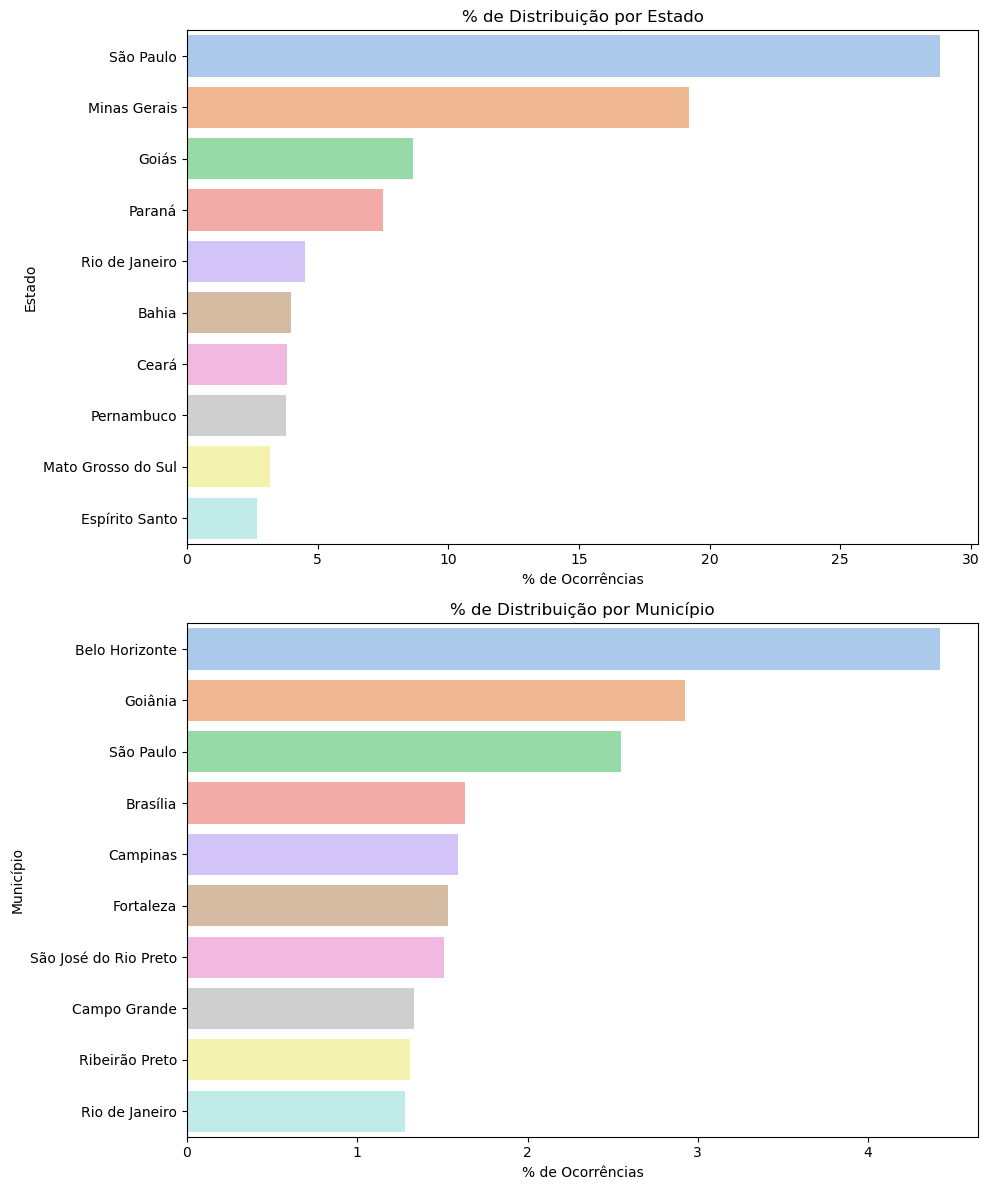

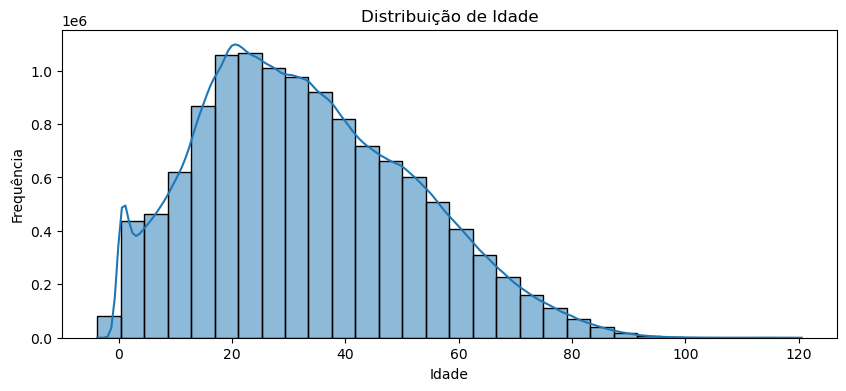

Média da idade: 33.46
Mediana da idade: 31.367556468172484

Tabela dos 10 primeiros Estados em %:
estado
São Paulo             28.832432
Minas Gerais          19.223011
Goiás                  8.645803
Paraná                 7.500131
Rio de Janeiro         4.513402
Bahia                  3.975883
Ceará                  3.837259
Pernambuco             3.769319
Mato Grosso do Sul     3.191762
Espírito Santo         2.665849
Name: proportion, dtype: float64

Tabela dos 10 primeiros Municípios em %:
municipio
Belo Horizonte           4.425839
Goiânia                  2.923638
São Paulo                2.546806
Brasília                 1.632325
Campinas                 1.593605
Fortaleza                1.534263
São José do Rio Preto    1.512045
Campo Grande             1.333751
Ribeirão Preto           1.308724
Rio de Janeiro           1.281838
Name: proportion, dtype: float64


In [19]:
warnings.filterwarnings("ignore")

def analisar_distribuicao(data_registers: pd.DataFrame) -> Tuple[float, float]:
    
    """
    Analisa a distribuição de estados e municípios em um DataFrame, plotando os resultados e
    calculando a média e a mediana da idade.

    Parameters:
    data_registers (pd.DataFrame): DataFrame contendo as colunas 'estado', 'municipio' e 'idade'.

    Returns:
    Tuple[float, float]: Retorna a média e a mediana da idade.
    """
    
    top_10_estados_pct = data_registers['estado'].value_counts(normalize=True).head(10) * 100
    top_10_municipios_pct = data_registers['municipio'].value_counts(normalize=True).head(10) * 100
    top_10_estados_pct = top_10_estados_pct.sort_values(ascending=False)
    top_10_municipios_pct = top_10_municipios_pct.sort_values(ascending=False)

    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    sns.barplot(x=top_10_estados_pct.values, y=top_10_estados_pct.index, ax=axes[0], palette="pastel")
    axes[0].set_title('% de Distribuição por Estado')
    axes[0].set_xlabel('% de Ocorrências')
    axes[0].set_ylabel('Estado')

    sns.barplot(x=top_10_municipios_pct.values, y=top_10_municipios_pct.index, ax=axes[1], palette="pastel")
    axes[1].set_title('% de Distribuição por Município')
    axes[1].set_xlabel('% de Ocorrências')
    axes[1].set_ylabel('Município')

    plt.tight_layout()

    plt.figure(figsize=(10, 4))
    sns.histplot(data_registers['idade'], kde=True, bins=30)
    plt.title('Distribuição de Idade')
    plt.xlabel('Idade')
    plt.ylabel('Frequência')
    plt.show()

    idade_media = data_registers['idade'].mean()
    idade_mediana = data_registers['idade'].median()

    print(f"Média da idade: {idade_media:.2f}")
    print(f"Mediana da idade: {idade_mediana}")

    print("\nTabela dos 10 primeiros Estados em %:")
    print(top_10_estados_pct)

    print("\nTabela dos 10 primeiros Municípios em %:")
    print(top_10_municipios_pct)
    
    return idade_media, idade_mediana


idade_media, idade_mediana = analisar_distribuicao(data_registers)


In [20]:
def limpar_e_preparar_registers(data_registers: pd.DataFrame, idade_mediana: int) -> pd.DataFrame:
    
    """
    Limpa e prepara o dataframe data_registers, preenchendo valores ausentes em várias colunas e 
    convertendo tipos de dados quando necessário. Seleciona um subconjunto de colunas e remove duplicatas.
    
    Parameters:
    data_registers (pd.DataFrame): DataFrame original contendo os registros dos pacientes.
    idade_mediana (int): O valor da mediana da idade para preencher valores ausentes na coluna 'idade'.
    
    Returns:
    pd.DataFrame: O novo DataFrame tratado, com valores ausentes preenchidos e duplicatas removidas.
    """
    
    data_registers['idade'] = data_registers['idade'].fillna(idade_mediana).astype(int)
    data_registers['idade'] = np.where(data_registers['idade']>100, idade_mediana, data_registers['idade'])
    data_registers['genero'] = data_registers['genero'].fillna('Não Identificado')
    data_registers['genero'] = np.where(data_registers['genero'] == 'I', 'Não Identificado', data_registers['genero'])
    data_registers['estado'] = data_registers['estado'].fillna('Não Identificado')
    data_registers['id_estado'] = data_registers['id_estado'].fillna(0).astype(int)
    data_registers['municipio'] = data_registers['municipio'].fillna('Não Identificado')
    data_registers['id_municipio'] = data_registers['id_municipio'].fillna(0).astype(int)
    data_registers['regiao'] = data_registers['regiao'].fillna('Não Identificado')
    data_registers['grupo_idade'] = data_registers['idade'].apply(determinar_grupo_idade)
    
    registers = data_registers.groupby(['ano', 'mes', 'mes_ano', 'genero', 'idade', 'grupo_idade', 'estado', 'municipio', 'regiao', 'obito']).agg({'pacientes':'sum'}).reset_index()
    
    return registers

registers = limpar_e_preparar_registers(data_registers, idade_mediana)


In [4]:
#registers.to_parquet('registers.parquet')
registers = pd.read_parquet('registers.parquet')

### Statistic Analysis

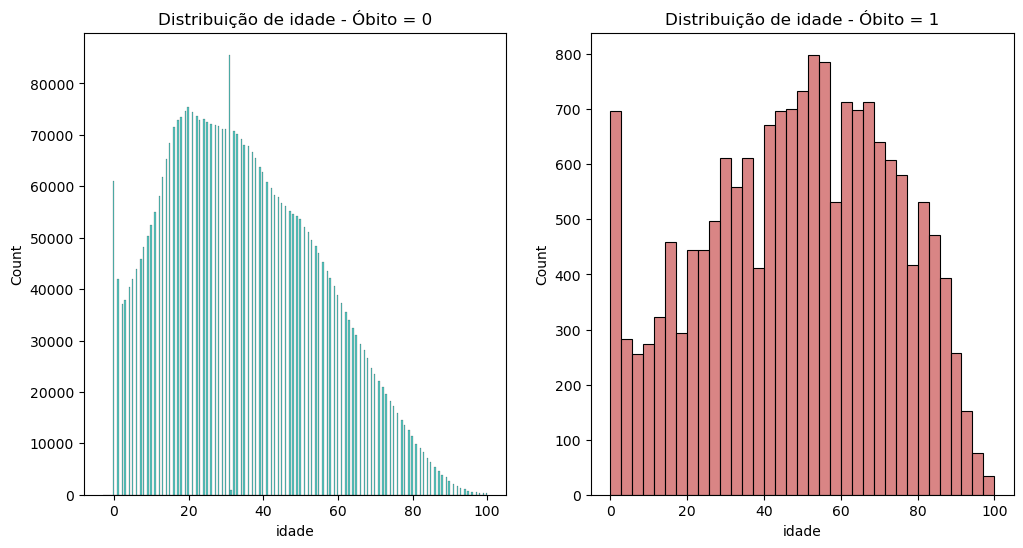

In [24]:
def plot_idade_por_obito(registers, cores_obito):
    
    """
    Plota histogramas de distribuição de idade para diferentes status de óbito.

    Parameters:
    registers (pd.DataFrame): DataFrame contendo as colunas 'idade' e 'obito'.

    Returns:
    None: A função apenas plota os gráficos.
    """
    
    cores_obito = {0: 'lightseagreen', 1: 'indianred'}
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes_flat = axes.flatten()

    for i, obito_status in enumerate(registers['obito'].unique()):
        sns.histplot(data=registers[registers['obito'] == obito_status], 
                     x='idade', color=cores_obito[obito_status], kde=False, 
                     ax=axes_flat[i])
        axes_flat[i].set_title(f'Distribuição de idade - Óbito = {obito_status}')

plot_idade_por_obito(registers, cores_obito)

In [25]:
registers.describe()

ano           mes         idade         obito     pacientes
count  4.175356e+06  4.175356e+06  4.175356e+06  4.175356e+06  4.175356e+06
mean   2.016442e+03  4.938758e+00  3.499214e+01  4.159406e-03  2.928492e+00
std    2.374440e+00  2.981672e+00  2.064420e+01  6.435920e-02  9.509126e+00
min    2.012000e+03  1.000000e+00 -3.000000e+00  0.000000e+00  1.000000e+00
25%    2.015000e+03  3.000000e+00  1.900000e+01  0.000000e+00  1.000000e+00
50%    2.016000e+03  4.000000e+00  3.300000e+01  0.000000e+00  1.000000e+00
75%    2.019000e+03  6.000000e+00  5.000000e+01  0.000000e+00  2.000000e+00
max    2.021000e+03  1.200000e+01  1.000000e+02  1.000000e+00  8.160000e+02

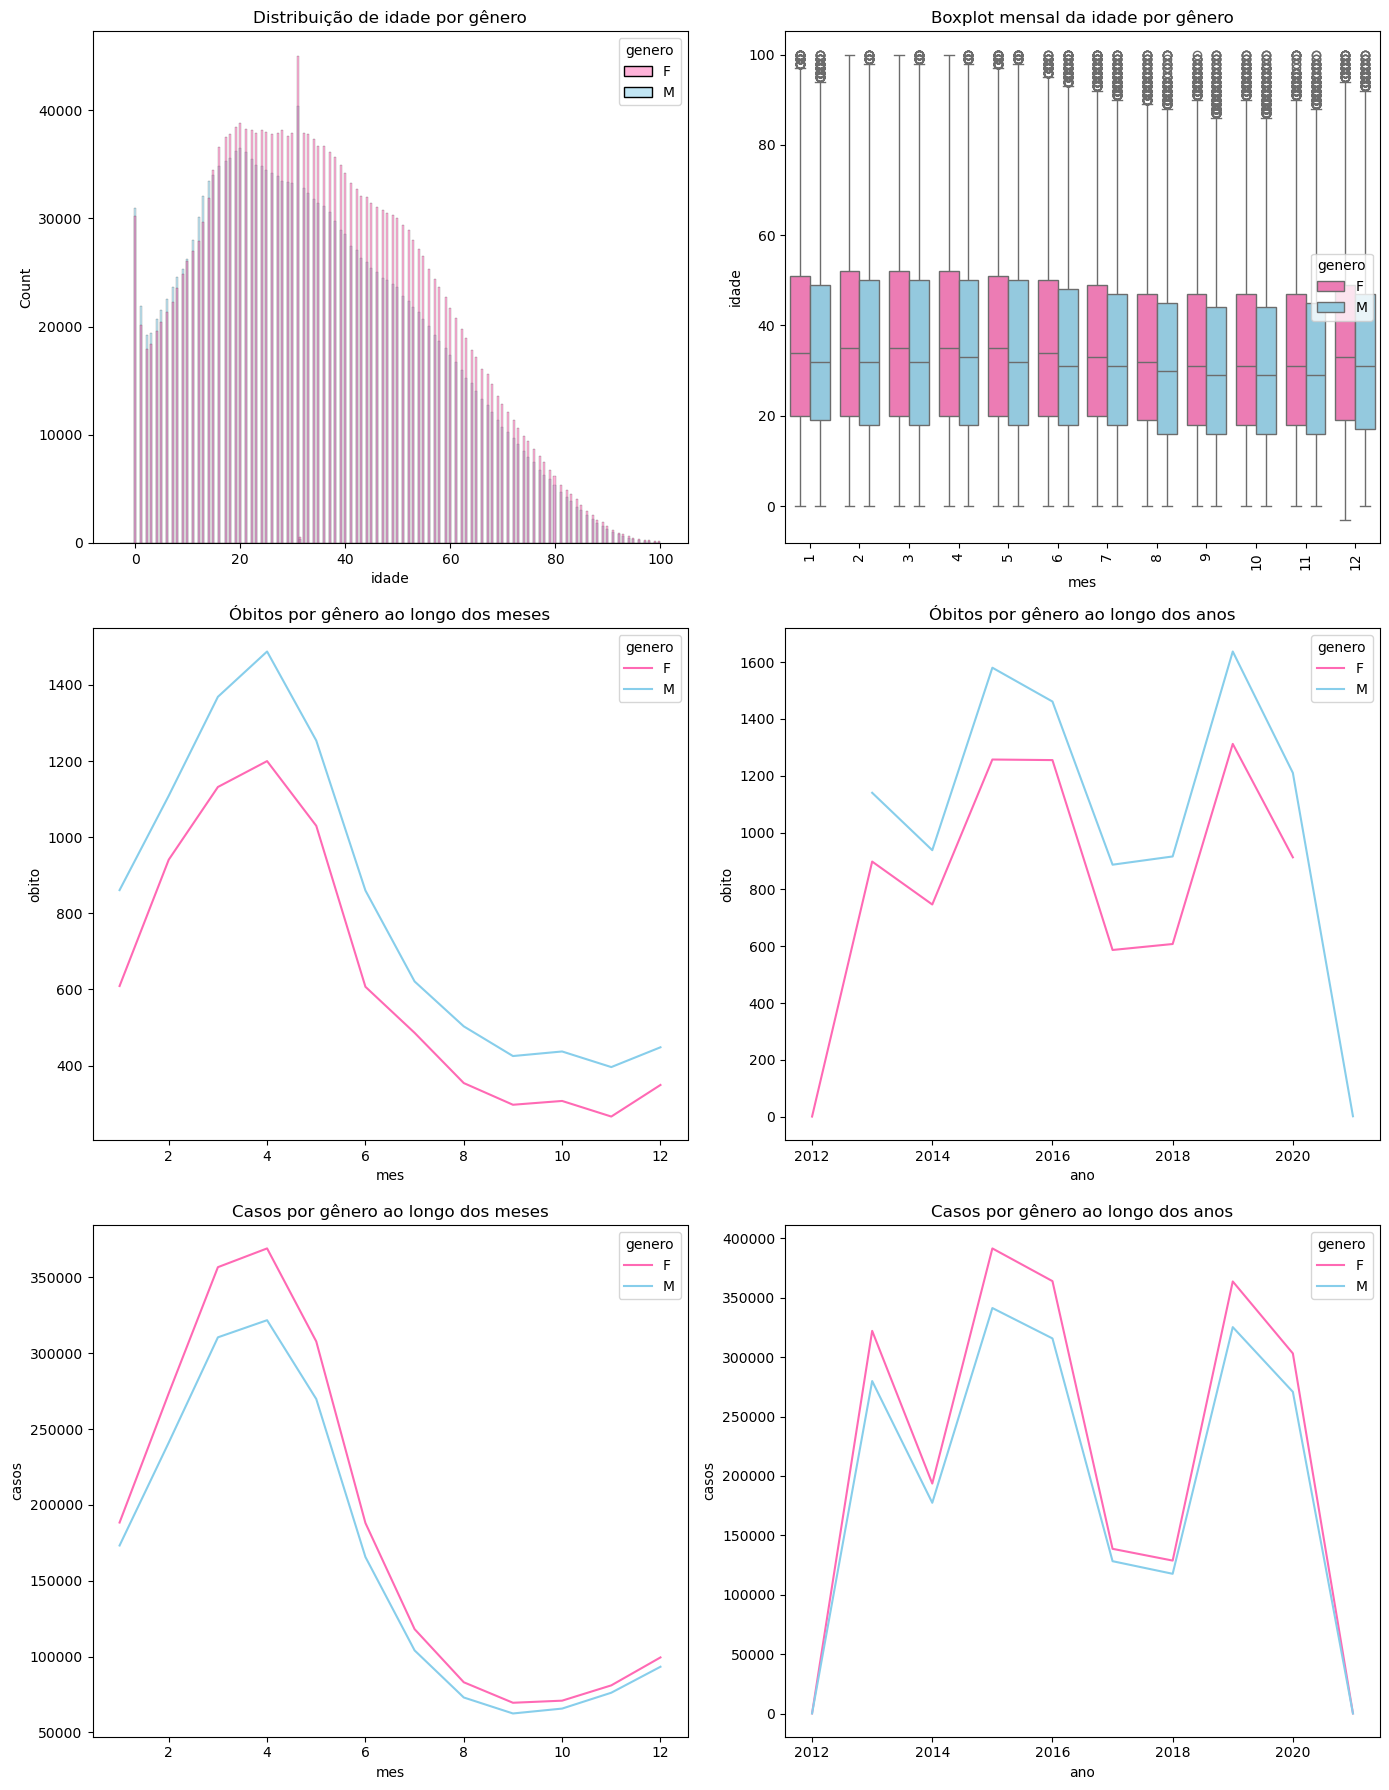

In [26]:
def criar_graficos_comparativos(data_registers: pd.DataFrame) -> None:
    
    """
    Cria uma série de gráficos para comparar distribuições e tendências em um DataFrame, excluindo valores "Não Identificado".

    Parameters:
    data_registers (pd.DataFrame): DataFrame contendo as colunas necessárias.

    Returns:
    None: A função apenas plota os gráficos.
    """
    
    data_clean = data_registers.replace('Não Identificado', np.nan).dropna()

    cores_obito = {0: 'lightseagreen', 1: 'indianred'}
    cores_genero = {'F': 'hotpink', 'M': 'skyblue'}
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 18))
    axes_flat = axes.flatten()

    sns.histplot(data=data_clean, x='idade', hue='genero', 
                 palette=cores_genero, kde=False, ax=axes_flat[0])
    axes_flat[0].set_title('Distribuição de idade por gênero')

    sns.boxplot(data=data_clean, x='mes', y='idade', hue='genero', 
                palette=cores_genero, ax=axes_flat[1])
    axes_flat[1].set_title('Boxplot mensal da idade por gênero')
    axes_flat[1].tick_params(axis='x', rotation=90)

    sns.lineplot(data=data_clean[data_clean['obito'] == 1], x='mes', y='obito', hue='genero', 
                 palette=cores_genero, ax=axes_flat[2], estimator='sum', ci=None)
    axes_flat[2].set_title('Óbitos por gênero ao longo dos meses')

    sns.lineplot(data=data_clean[data_clean['obito'] == 1], x='ano', y='obito', hue='genero', 
                 palette=cores_genero, ax=axes_flat[3], estimator='sum', ci=None)
    axes_flat[3].set_title('Óbitos por gênero ao longo dos anos')

    casos_por_mes_genero = data_clean.groupby(['mes', 'genero']).size().reset_index(name='casos')
    sns.lineplot(data=casos_por_mes_genero, x='mes', y='casos', hue='genero', 
                 palette=cores_genero, ax=axes_flat[4])
    axes_flat[4].set_title('Casos por gênero ao longo dos meses')

    casos_por_ano_genero = data_clean.groupby(['ano', 'genero']).size().reset_index(name='casos')
    sns.lineplot(data=casos_por_ano_genero, x='ano', y='casos', hue='genero', 
                 palette=cores_genero, ax=axes_flat[5])
    axes_flat[5].set_title('Casos por gênero ao longo dos anos')

    plt.tight_layout()
    plt.show()


criar_graficos_comparativos(registers)


### Timeseries Analysis

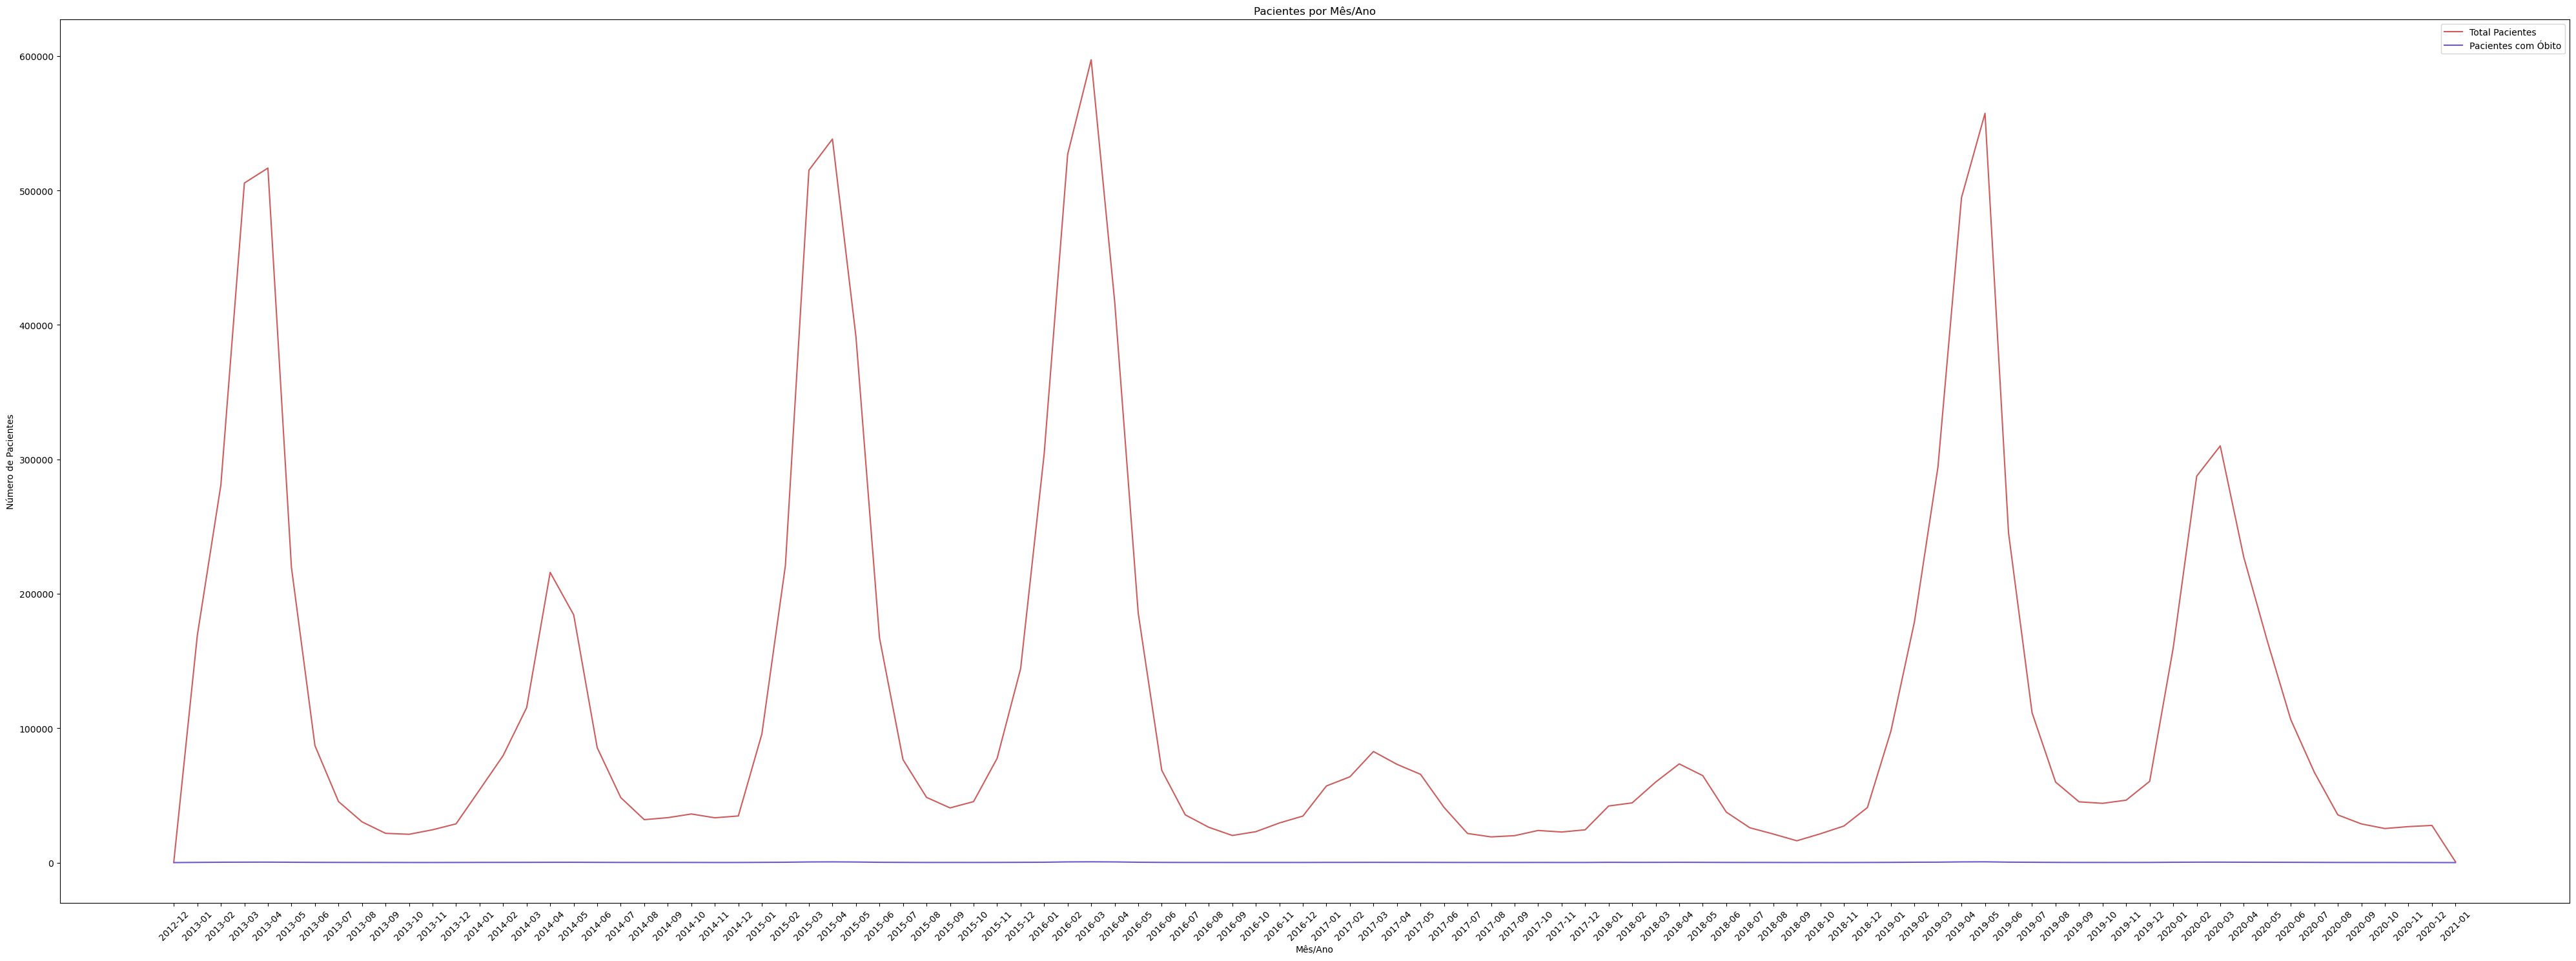

In [27]:
def plot_pacientes_obito(registers: pd.DataFrame) -> None:
    
    """
    Plota dois gráficos de linhas: um para o total de pacientes por mês_ano e outro para pacientes com óbito=1 por mês_ano.
    
    Parâmetros:
    - registers (pd.DataFrame): DataFrame contendo as colunas mes_ano, pacientes e obito.
    
    A função não retorna nada, mas exibe um gráfico.
    """

    tmp1 = registers.groupby('mes_ano')['pacientes'].sum().reset_index()
    tmp2 = registers[registers['obito'] == 1].groupby('mes_ano')['pacientes'].sum().reset_index()
    
    plt.figure(figsize=(40, 15))
    
    plt.plot(tmp1['mes_ano'], tmp1['pacientes'], label='Total Pacientes', color='indianred')
    
    plt.plot(tmp2['mes_ano'], tmp2['pacientes'], label='Pacientes com Óbito', color='slateblue')
    
    plt.title('Pacientes por Mês/Ano')
    plt.xlabel('Mês/Ano')
    plt.ylabel('Número de Pacientes')
    plt.xticks(rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    
plot_pacientes_obito(registers)

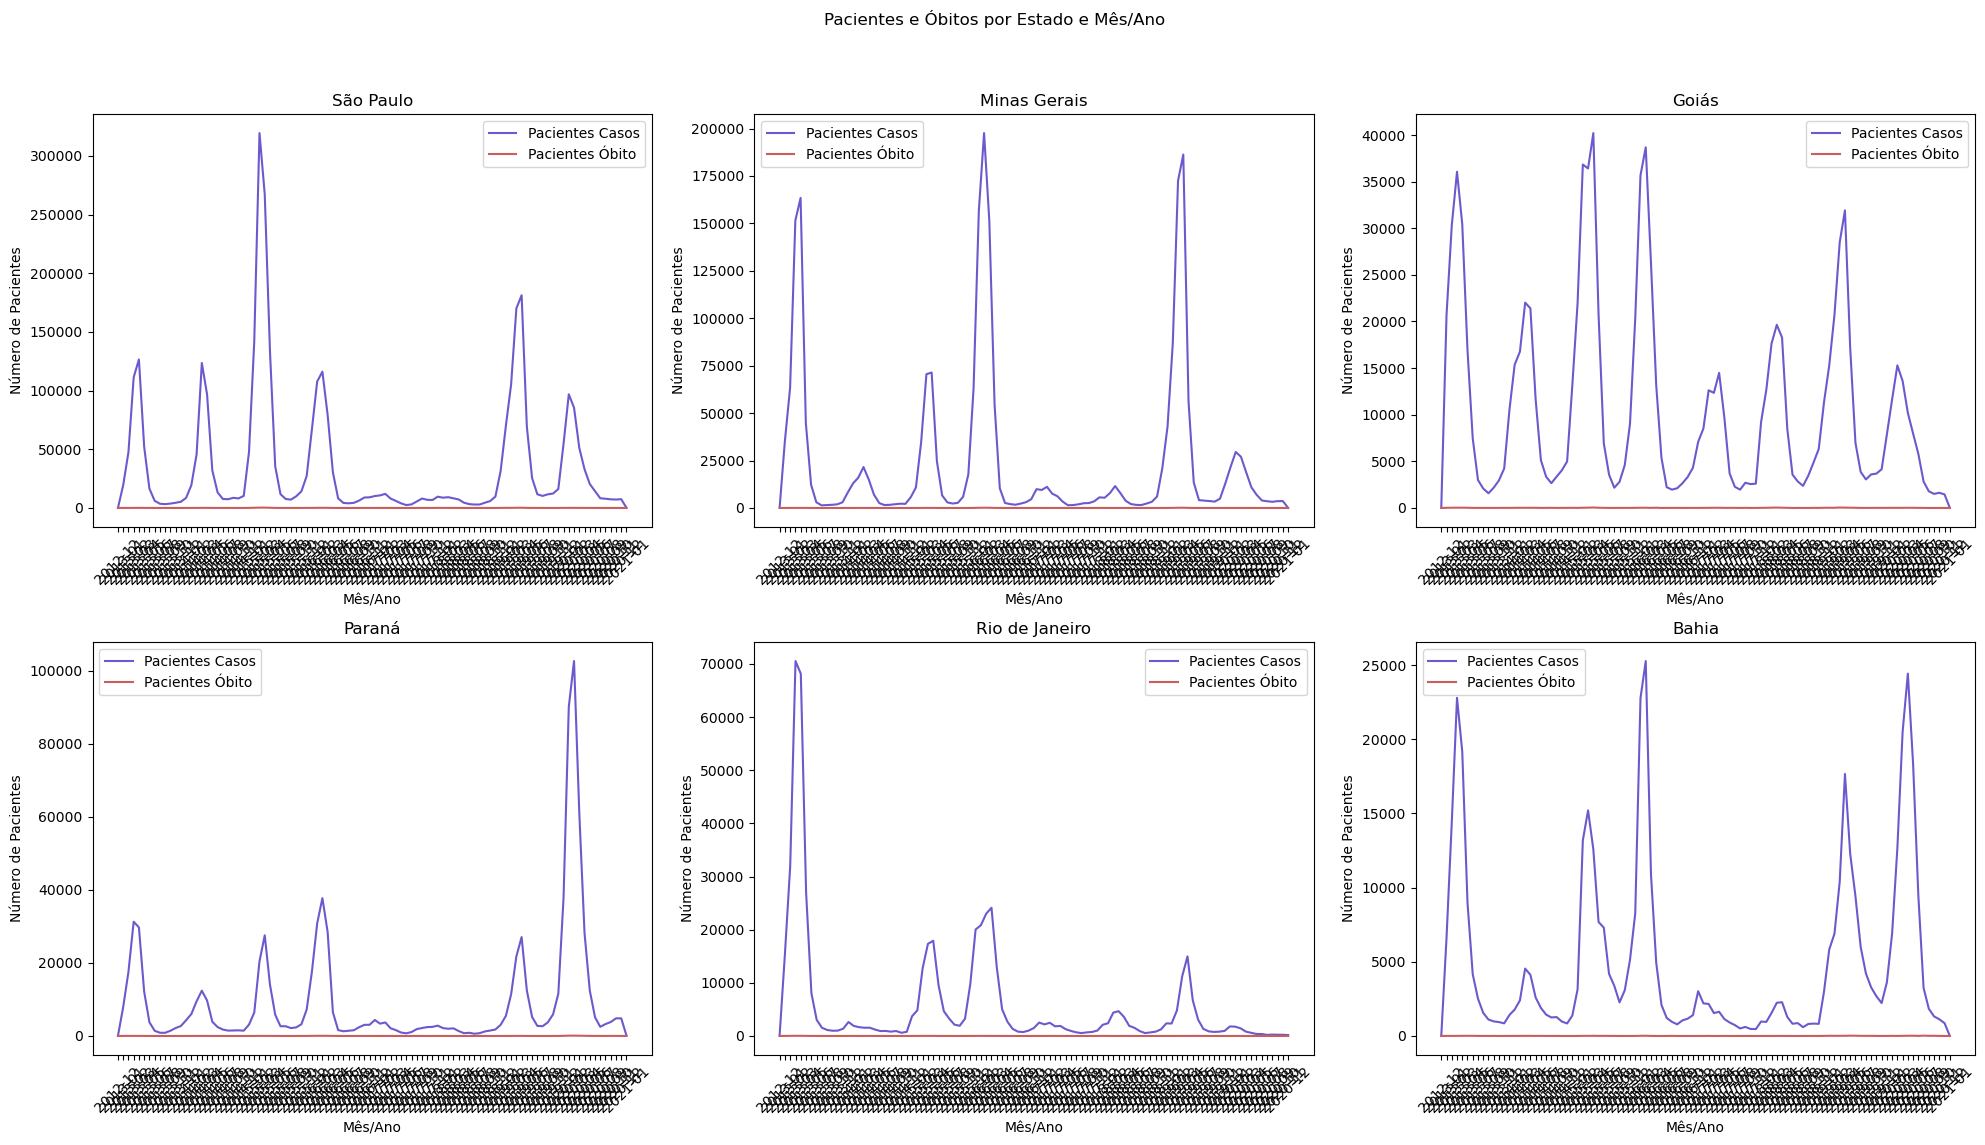

In [28]:
def plot_estado_pacientes_obito(registers: pd.DataFrame) -> None:
    
    """
    Plota seis subgráficos, cada um representando um dos top 6 estados com maior número de pacientes.
    Cada gráfico exibe duas linhas: uma para o total de pacientes e outra para pacientes com óbito.
    
    Parâmetros:
    - registers (pd.DataFrame): DataFrame contendo as colunas estado, mes_ano, pacientes e obito.
    
    A função não retorna nada, mas exibe gráficos.
    """
    
    top_6_states = registers.groupby(['estado']).agg({'pacientes':'sum'}).sort_values('pacientes', ascending=False).reset_index().head(6)['estado'].tolist()
    
    tmp = registers[registers.estado.isin(top_6_states)].groupby(['estado','mes_ano']).agg({'pacientes':'sum'}).sort_values(['mes_ano','estado'], ascending=[True, True]).reset_index()
    tmp2 = registers[(registers.estado.isin(top_6_states)) & (registers.obito == 1)].groupby(['estado','mes_ano']).agg({'pacientes':'sum'}).sort_values(['mes_ano','estado'], ascending=[True, True]).reset_index()
    tmp3 = tmp.merge(tmp2, on=['estado', 'mes_ano'], how='left', suffixes=('_casos', '_obito')).fillna(0)
    tmp3['pacientes_obito'] = tmp3['pacientes_obito'].astype(int)
    
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Pacientes e Óbitos por Estado e Mês/Ano')
    
    for idx, estado in enumerate(top_6_states):
        ax = axs[idx // 3, idx % 3]
        estado_data = tmp3[tmp3['estado'] == estado]
        
        ax.plot(estado_data['mes_ano'], estado_data['pacientes_casos'], label='Pacientes Casos', color='slateblue')
        ax.plot(estado_data['mes_ano'], estado_data['pacientes_obito'], label='Pacientes Óbito', color='indianred')
        
        ax.set_title(estado)
        ax.set_xlabel('Mês/Ano')
        ax.set_ylabel('Número de Pacientes')
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    
plot_estado_pacientes_obito(registers)    

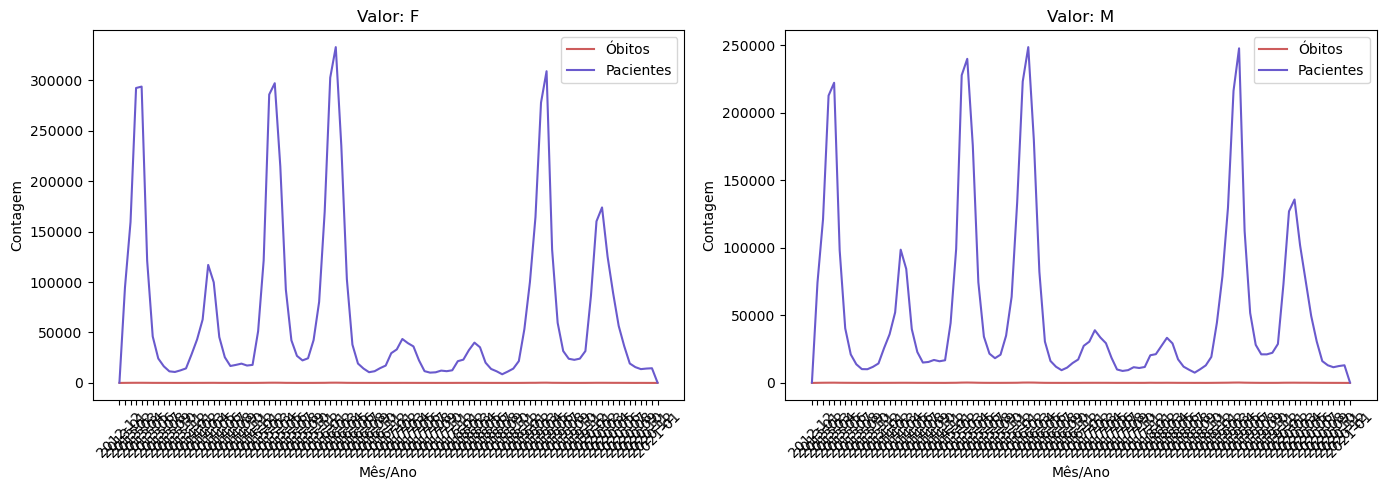

In [29]:
def plot_time_series_by_column(data: pd.DataFrame, column_name: str) -> None:
    
    """
    Plota gráficos de séries temporais para os valores da coluna escolhida no DataFrame.
    
    Parâmetros:
        data (pd.DataFrame): O DataFrame com os registros.
        column_name (str): O nome da coluna para agrupar e plotar os dados ('genero', 'grupo_idade', 'regiao').
        
    A função não retorna nada, mas exibe gráficos de séries temporais.
    """
    
    data = data.replace('Não Identificado', np.nan).dropna()
    
    
    if column_name not in ['genero', 'grupo_idade', 'regiao']:
        raise ValueError("A coluna escolhida deve ser 'genero', 'grupo_idade' ou 'regiao'.")
    
    df_obitos = data.groupby(['mes_ano', column_name, 'obito']).size().unstack(fill_value=0).reset_index()
    
    df_pacientes = data.groupby(['mes_ano', column_name])['pacientes'].sum().reset_index()
    
    unique_values = data[column_name].unique()
    
    n_rows = len(unique_values) // 2 + len(unique_values) % 2
    fig, axs = plt.subplots(n_rows, 2, figsize=(14, n_rows * 5))
    
    for i, value in enumerate(unique_values):
        ax = axs[i // 2, i % 2] if n_rows > 1 else axs[i]
        df_obitos_value = df_obitos[df_obitos[column_name] == value]
        df_pacientes_value = df_pacientes[df_pacientes[column_name] == value]
        
        ax.plot(df_obitos_value['mes_ano'], df_obitos_value[1], label='Óbitos', color='indianred')
        ax.plot(df_pacientes_value['mes_ano'], df_pacientes_value['pacientes'], label='Pacientes', color='slateblue')
        
        ax.set_title(f"Valor: {value}")
        ax.set_xlabel('Mês/Ano')
        ax.set_ylabel('Contagem')
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        
    plt.tight_layout()
    plt.show()

plot_time_series_by_column(registers, 'genero')


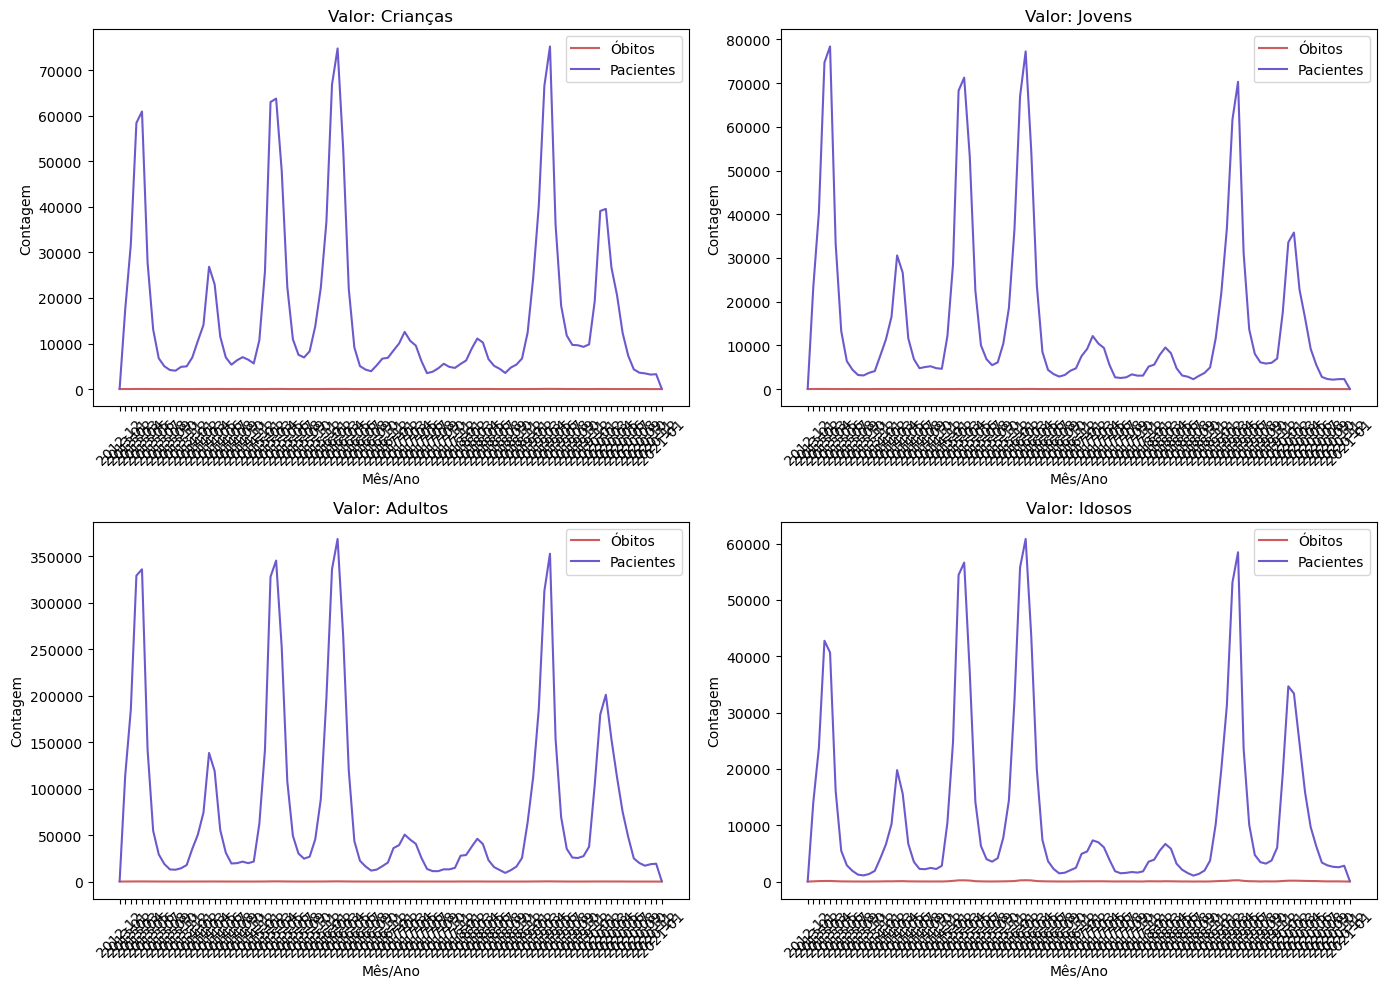

In [30]:
plot_time_series_by_column(registers, 'grupo_idade')

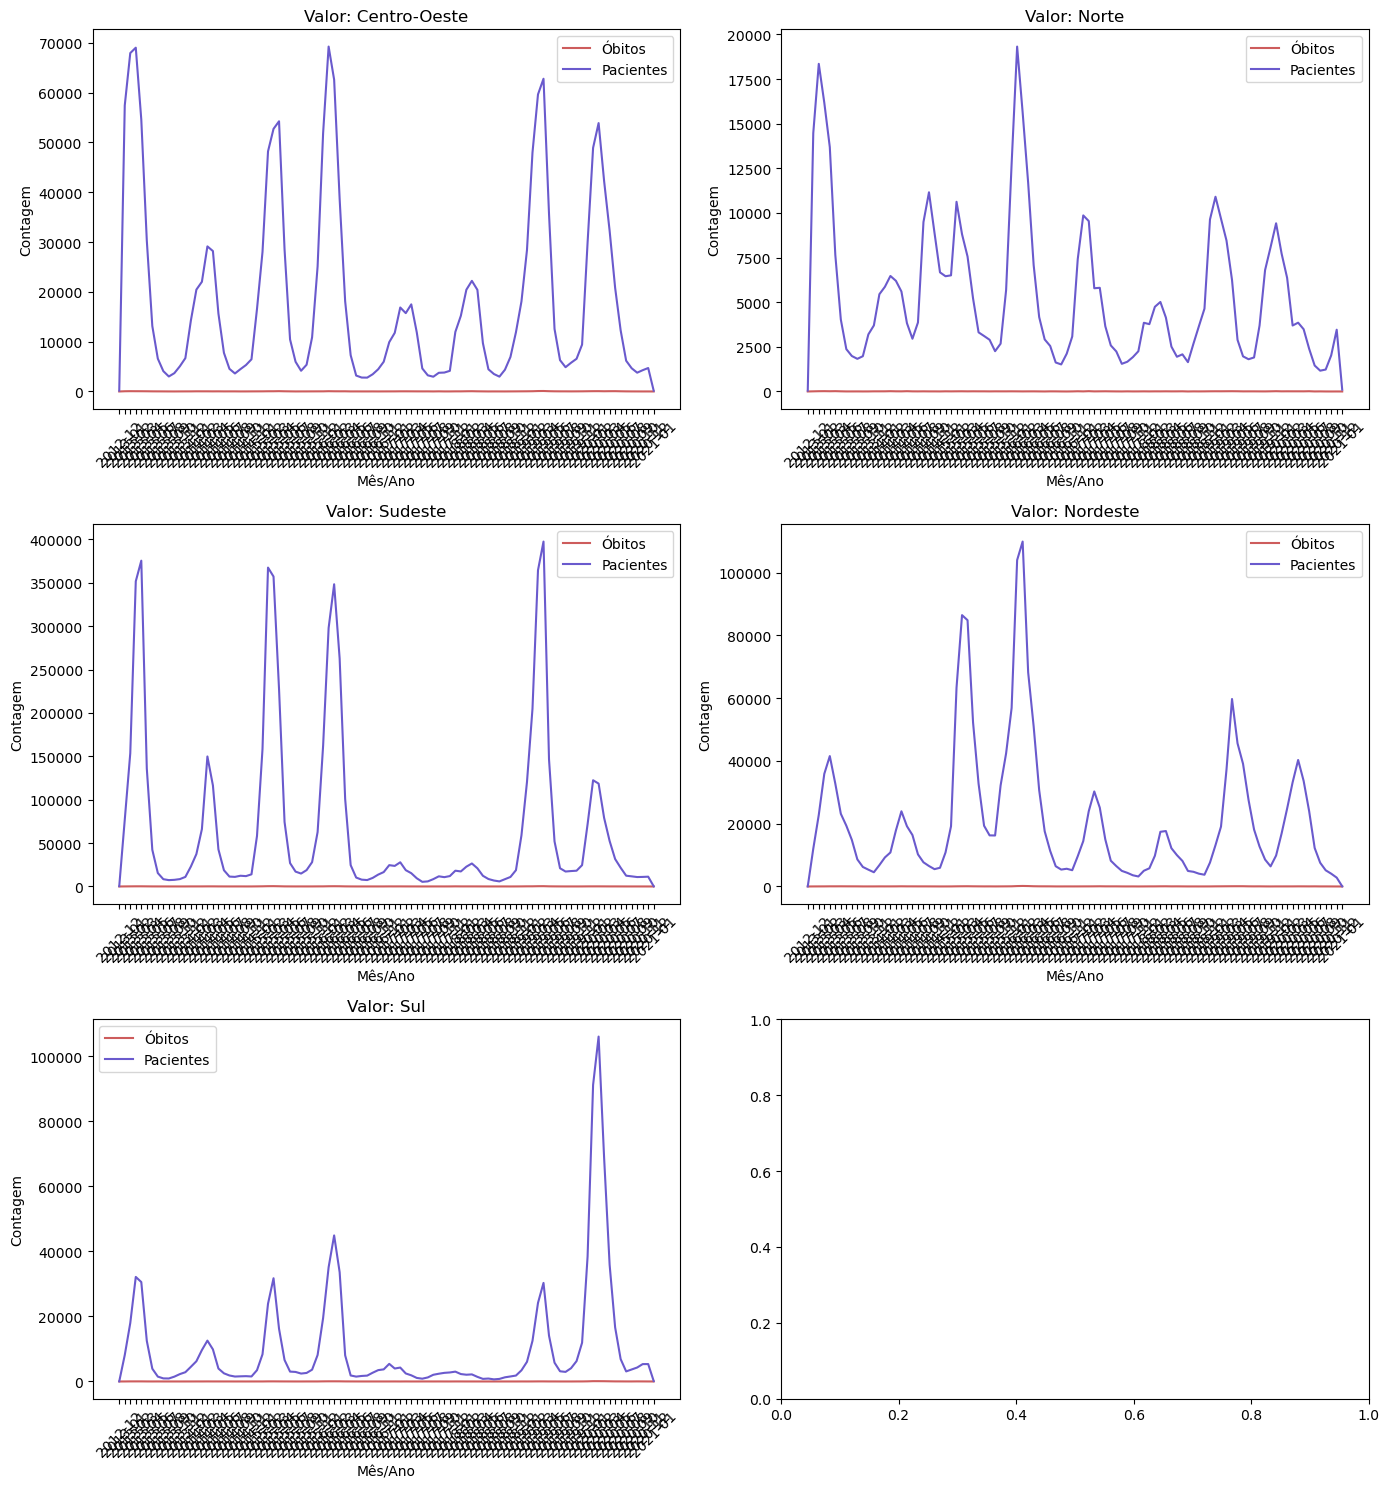

In [31]:
plot_time_series_by_column(registers, 'regiao')

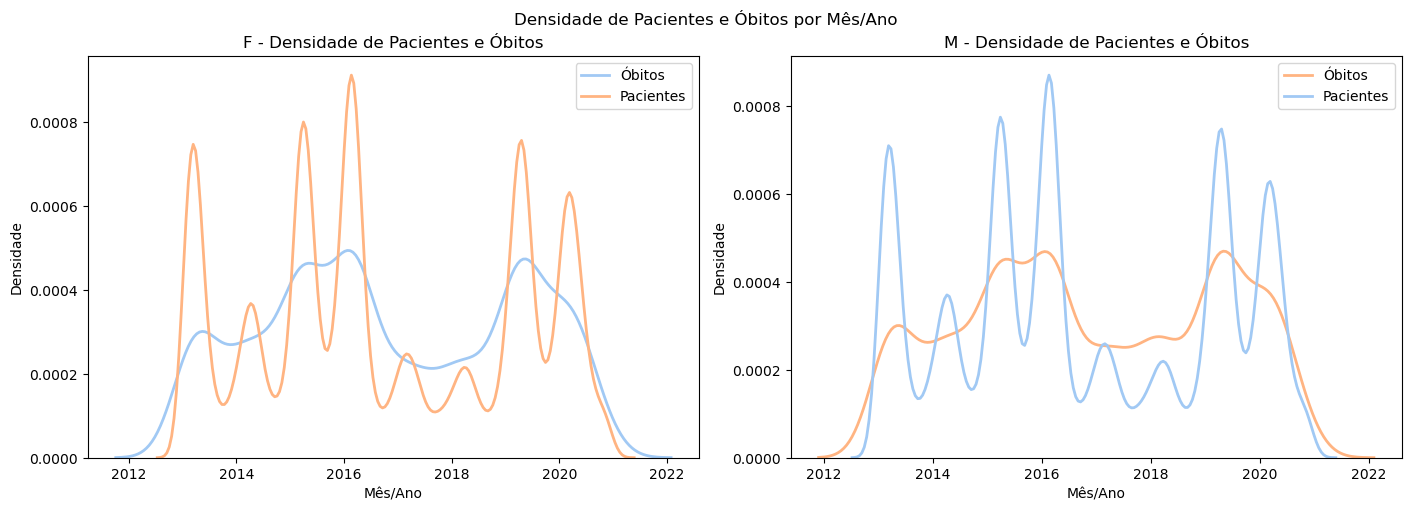

In [32]:
def plot_density_time_series_by_column(data: pd.DataFrame, column_name: str) -> None:
    
    """
    Plota gráficos de densidade de séries temporais para os valores da coluna escolhida no DataFrame.
    
    Parâmetros:
        data (pd.DataFrame): O DataFrame com os registros.
        column_name (str): O nome da coluna para agrupar e plotar os dados ('genero', 'grupo_idade', 'regiao').
        
    A função não retorna nada, mas exibe gráficos de densidade de séries temporais.
    """
    
    data = data.replace('Não Identificado', np.nan).dropna()

    if column_name not in ['genero', 'grupo_idade', 'regiao']:
        raise ValueError("A coluna escolhida deve ser 'genero', 'grupo_idade' ou 'regiao'.")

    data['mes_ano_datetime'] = pd.to_datetime(data['mes_ano'])

    unique_values = data[column_name].unique()
    
    n_rows = len(unique_values) // 2 + len(unique_values) % 2
    fig, axs = plt.subplots(n_rows, 2, figsize=(14, n_rows * 5), constrained_layout=True)
    fig.suptitle('Densidade de Pacientes e Óbitos por Mês/Ano')

    palette = sns.color_palette('pastel', len(unique_values))
    
    for i, value in enumerate(unique_values):

        if n_rows > 1:
            ax = axs[i // 2, i % 2]
        else:
            ax = axs[i % 2]
        
        subset_data = data[data[column_name] == value]
        
        sns.kdeplot(data=subset_data[subset_data['obito'] == 1], x='mes_ano_datetime', 
                    ax=ax, label='Óbitos', color=palette[i % len(palette)], linewidth=2)
        
        sns.kdeplot(data=subset_data, x='mes_ano_datetime', 
                    ax=ax, label='Pacientes', color=palette[(i + 1) % len(palette)], linewidth=2)
        
        ax.set_title(f"{value} - Densidade de Pacientes e Óbitos")
        ax.set_xlabel('Mês/Ano')
        ax.set_ylabel('Densidade')
        ax.legend()
        
    plt.show()

plot_density_time_series_by_column(data=registers, column_name='genero')


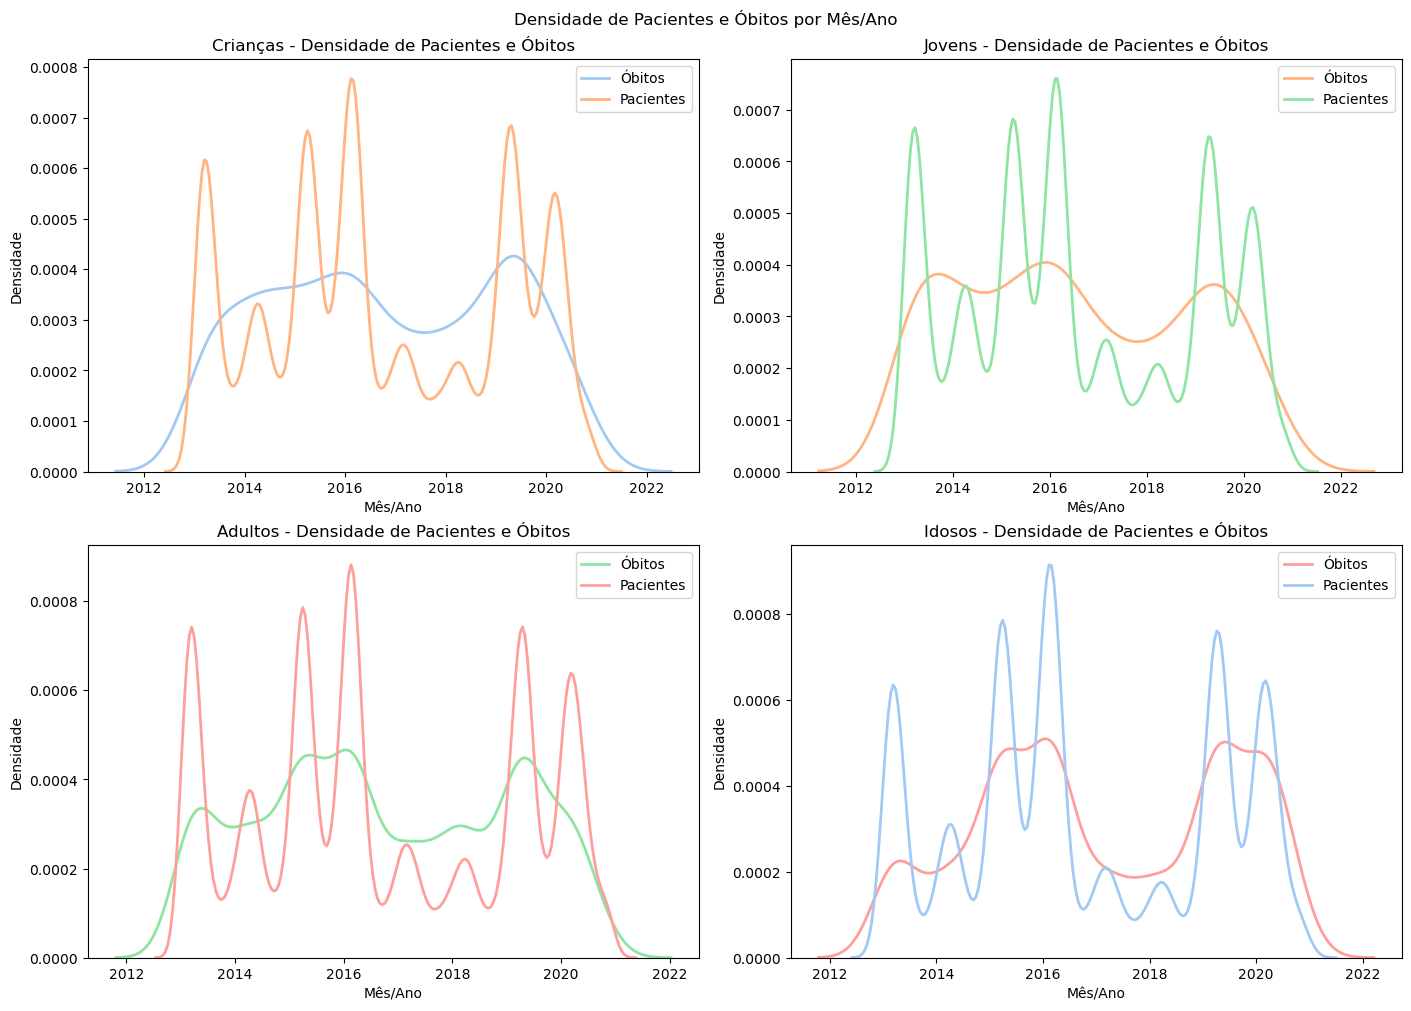

In [33]:
plot_density_time_series_by_column(data=registers, column_name='grupo_idade')

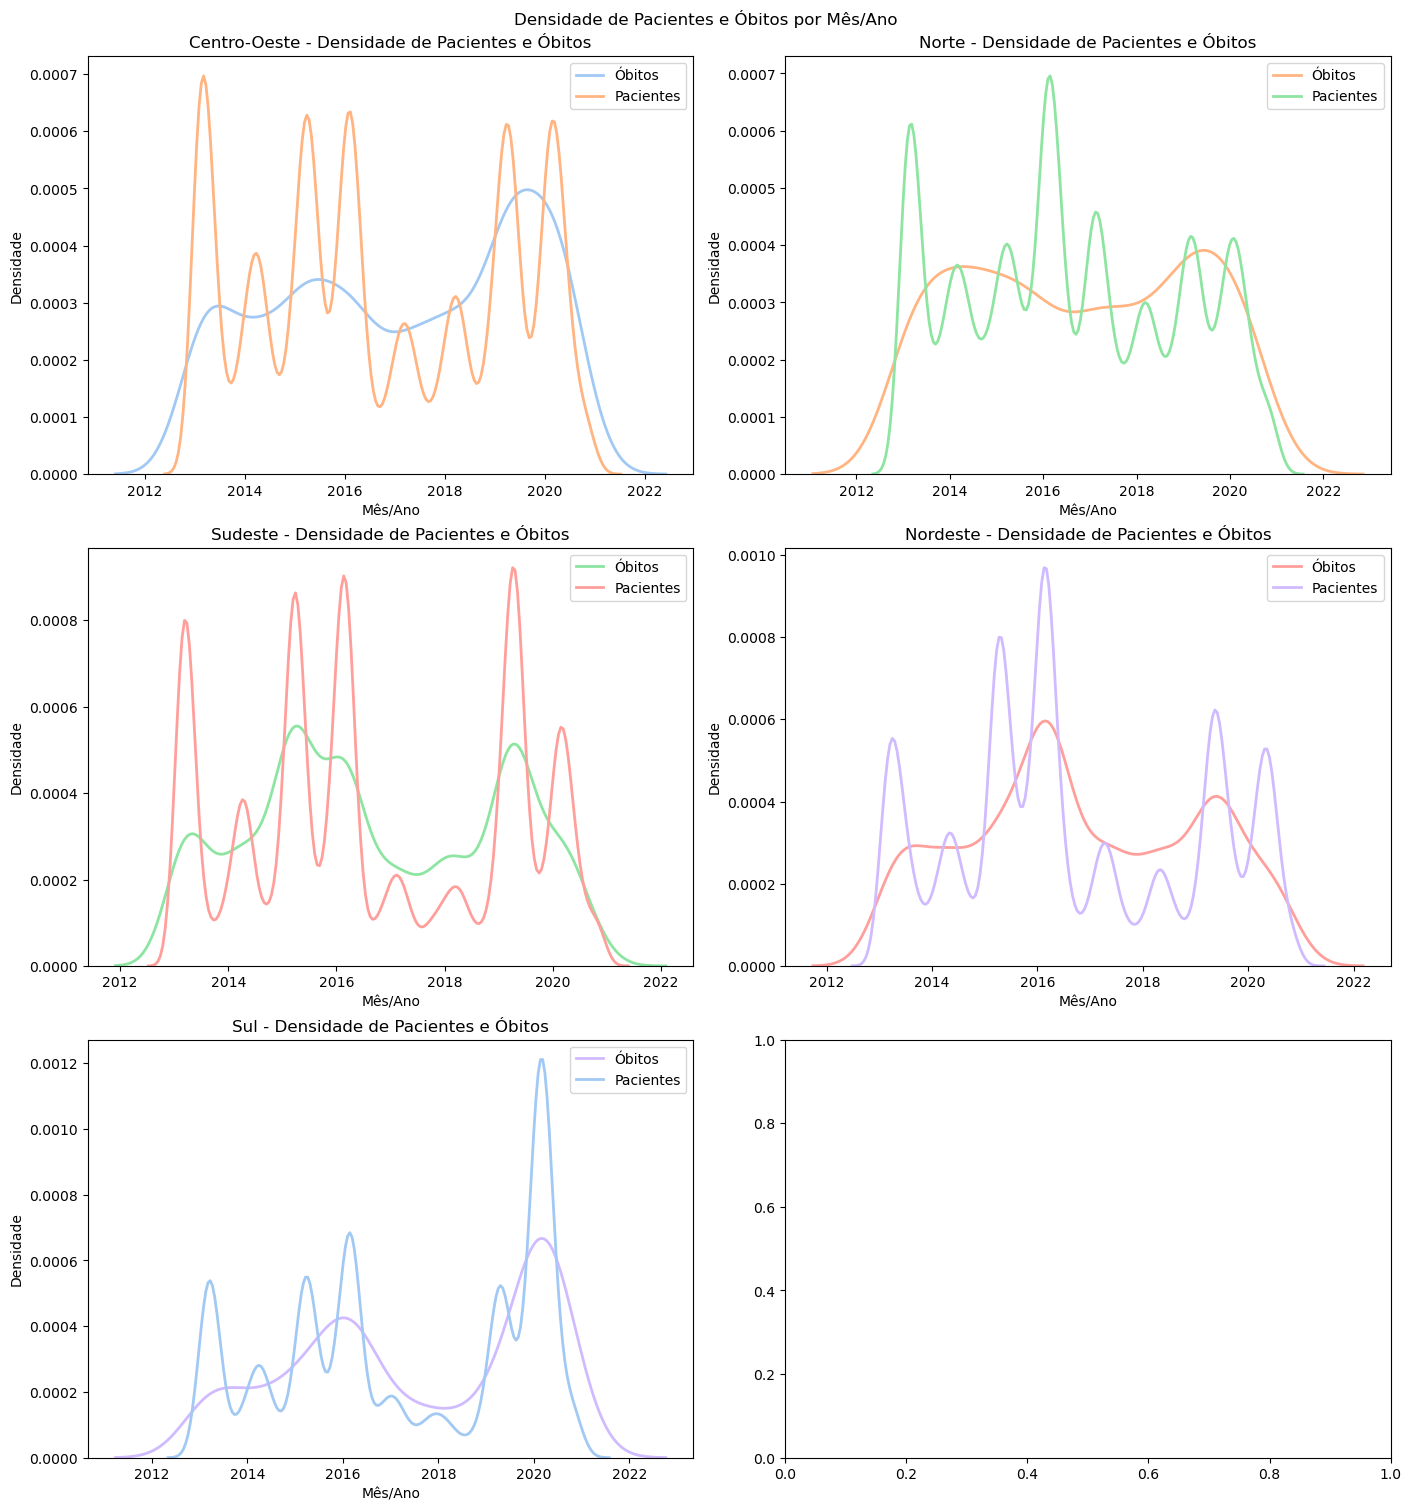

In [34]:
plot_density_time_series_by_column(data=registers, column_name='regiao')

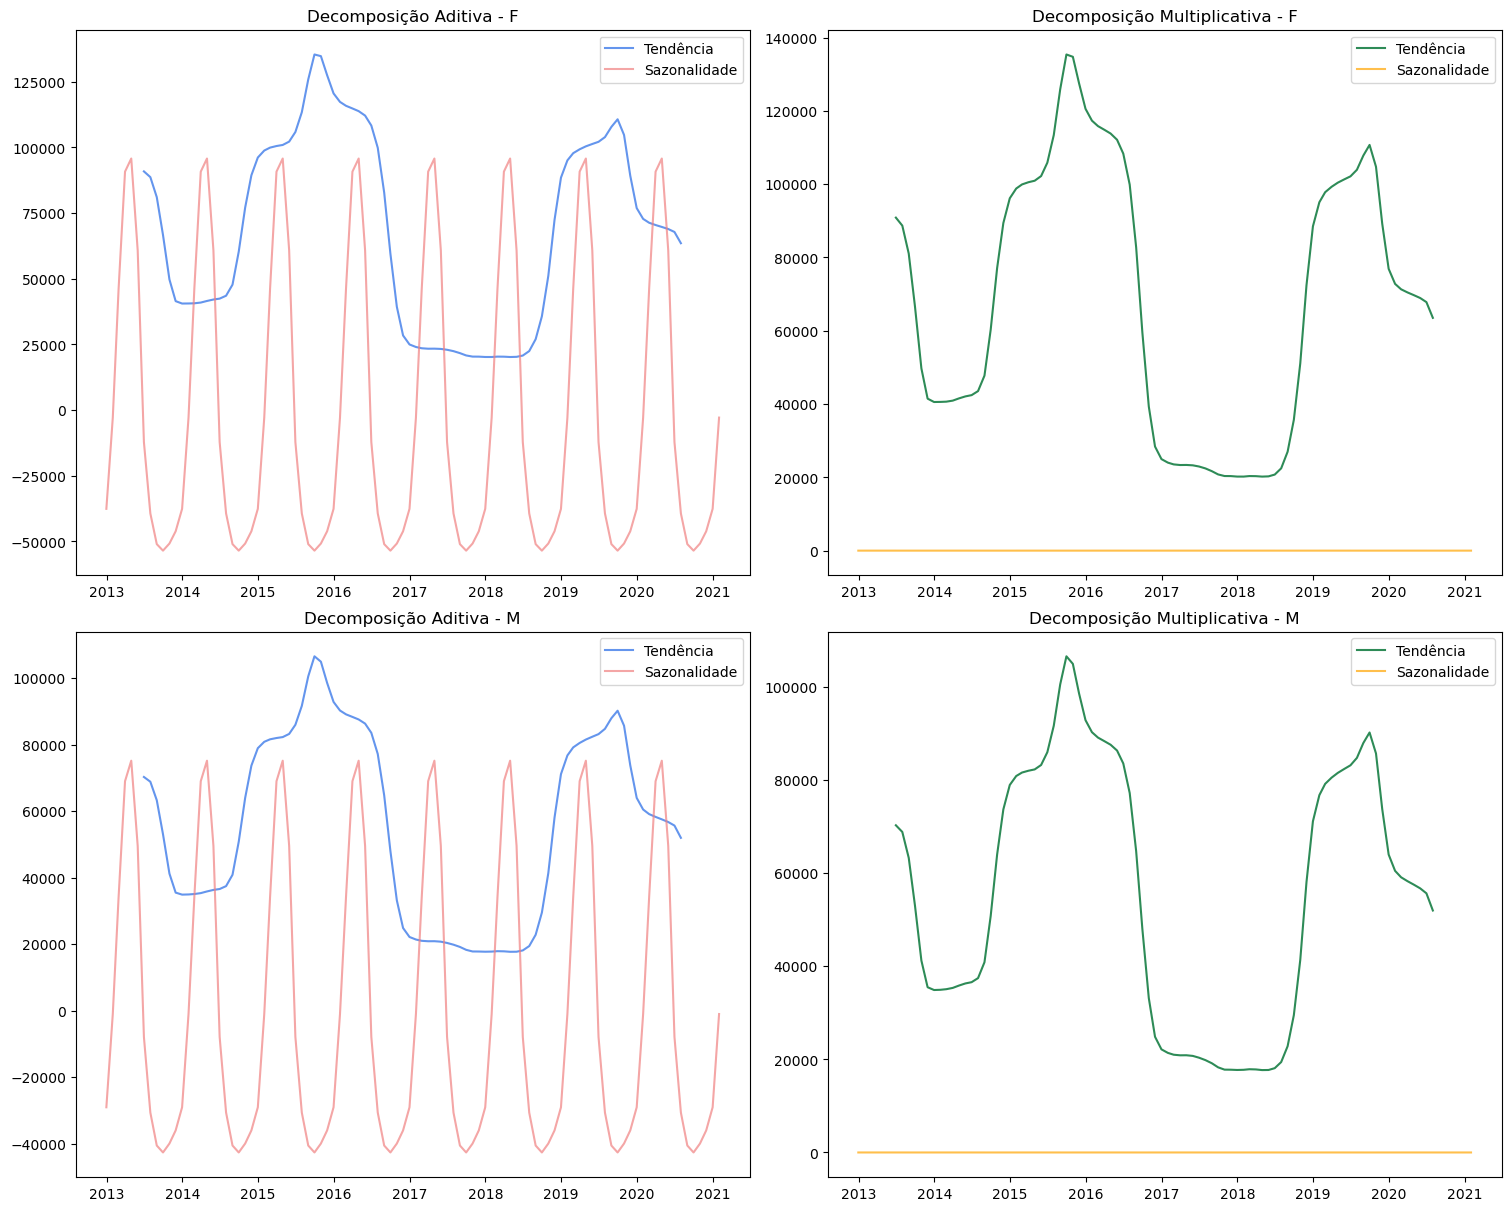

In [35]:
def plot_time_series_decomposition(data: pd.DataFrame, column_name: str, period: int = 12) -> None:
    
    """
    Plota a decomposição aditiva e multiplicativa das séries temporais para cada valor único da coluna escolhida.
    Os gráficos são exibidos em subplots com a decomposição aditiva na coluna esquerda e multiplicativa na direita.

    Parâmetros:
        data (pd.DataFrame): O DataFrame com os registros.
        column_name (str): O nome da coluna para agrupar e plotar os dados ('genero', 'grupo_idade', 'regiao').
        period (int): O período da sazonalidade para a decomposição.

    A função não retorna nada, mas exibe os gráficos de decomposição.
    """
    
    data = data.replace('Não Identificado', np.nan).dropna()
    
    if column_name not in ['genero', 'grupo_idade', 'regiao']:
        raise ValueError("A coluna escolhida deve ser 'genero', 'grupo_idade' ou 'regiao'.")

    unique_values = data[column_name].unique()
    
    n_rows = len(unique_values)
    fig, axs = plt.subplots(n_rows, 2, figsize=(15, n_rows * 6), constrained_layout=True)
    
    if n_rows == 1:
        axs = [axs]
        
    for i, value in enumerate(unique_values):

        subset_data = data[data[column_name] == value].copy()
        subset_data['mes_ano_datetime'] = pd.to_datetime(subset_data['mes_ano'])
        subset_data.set_index('mes_ano_datetime', inplace=True)
        
        time_series = subset_data['pacientes'].resample('M').sum()
        
        time_series = time_series.fillna(0)
        
        if len(time_series) < 2 * period:
            print(f'Não há dados suficientes para decompor a série temporal para {value}.')
            continue
        
        decomposition_additive = seasonal_decompose(time_series, model='additive', period=period)
        decomposition_multiplicative = seasonal_decompose(time_series, model='multiplicative', period=period)
        
        axs[i, 0].plot(decomposition_additive.trend, label='Tendência', color='cornflowerblue')
        axs[i, 0].plot(decomposition_additive.seasonal, label='Sazonalidade', color='lightcoral', alpha=0.7)
        axs[i, 0].set_title(f'Decomposição Aditiva - {value}')
        axs[i, 0].legend()
        
        axs[i, 1].plot(decomposition_multiplicative.trend, label='Tendência', color='seagreen')
        axs[i, 1].plot(decomposition_multiplicative.seasonal, label='Sazonalidade', color='orange', alpha=0.7)
        axs[i, 1].set_title(f'Decomposição Multiplicativa - {value}')
        axs[i, 1].legend()
    
    plt.show()

plot_time_series_decomposition(data=registers, column_name='genero')


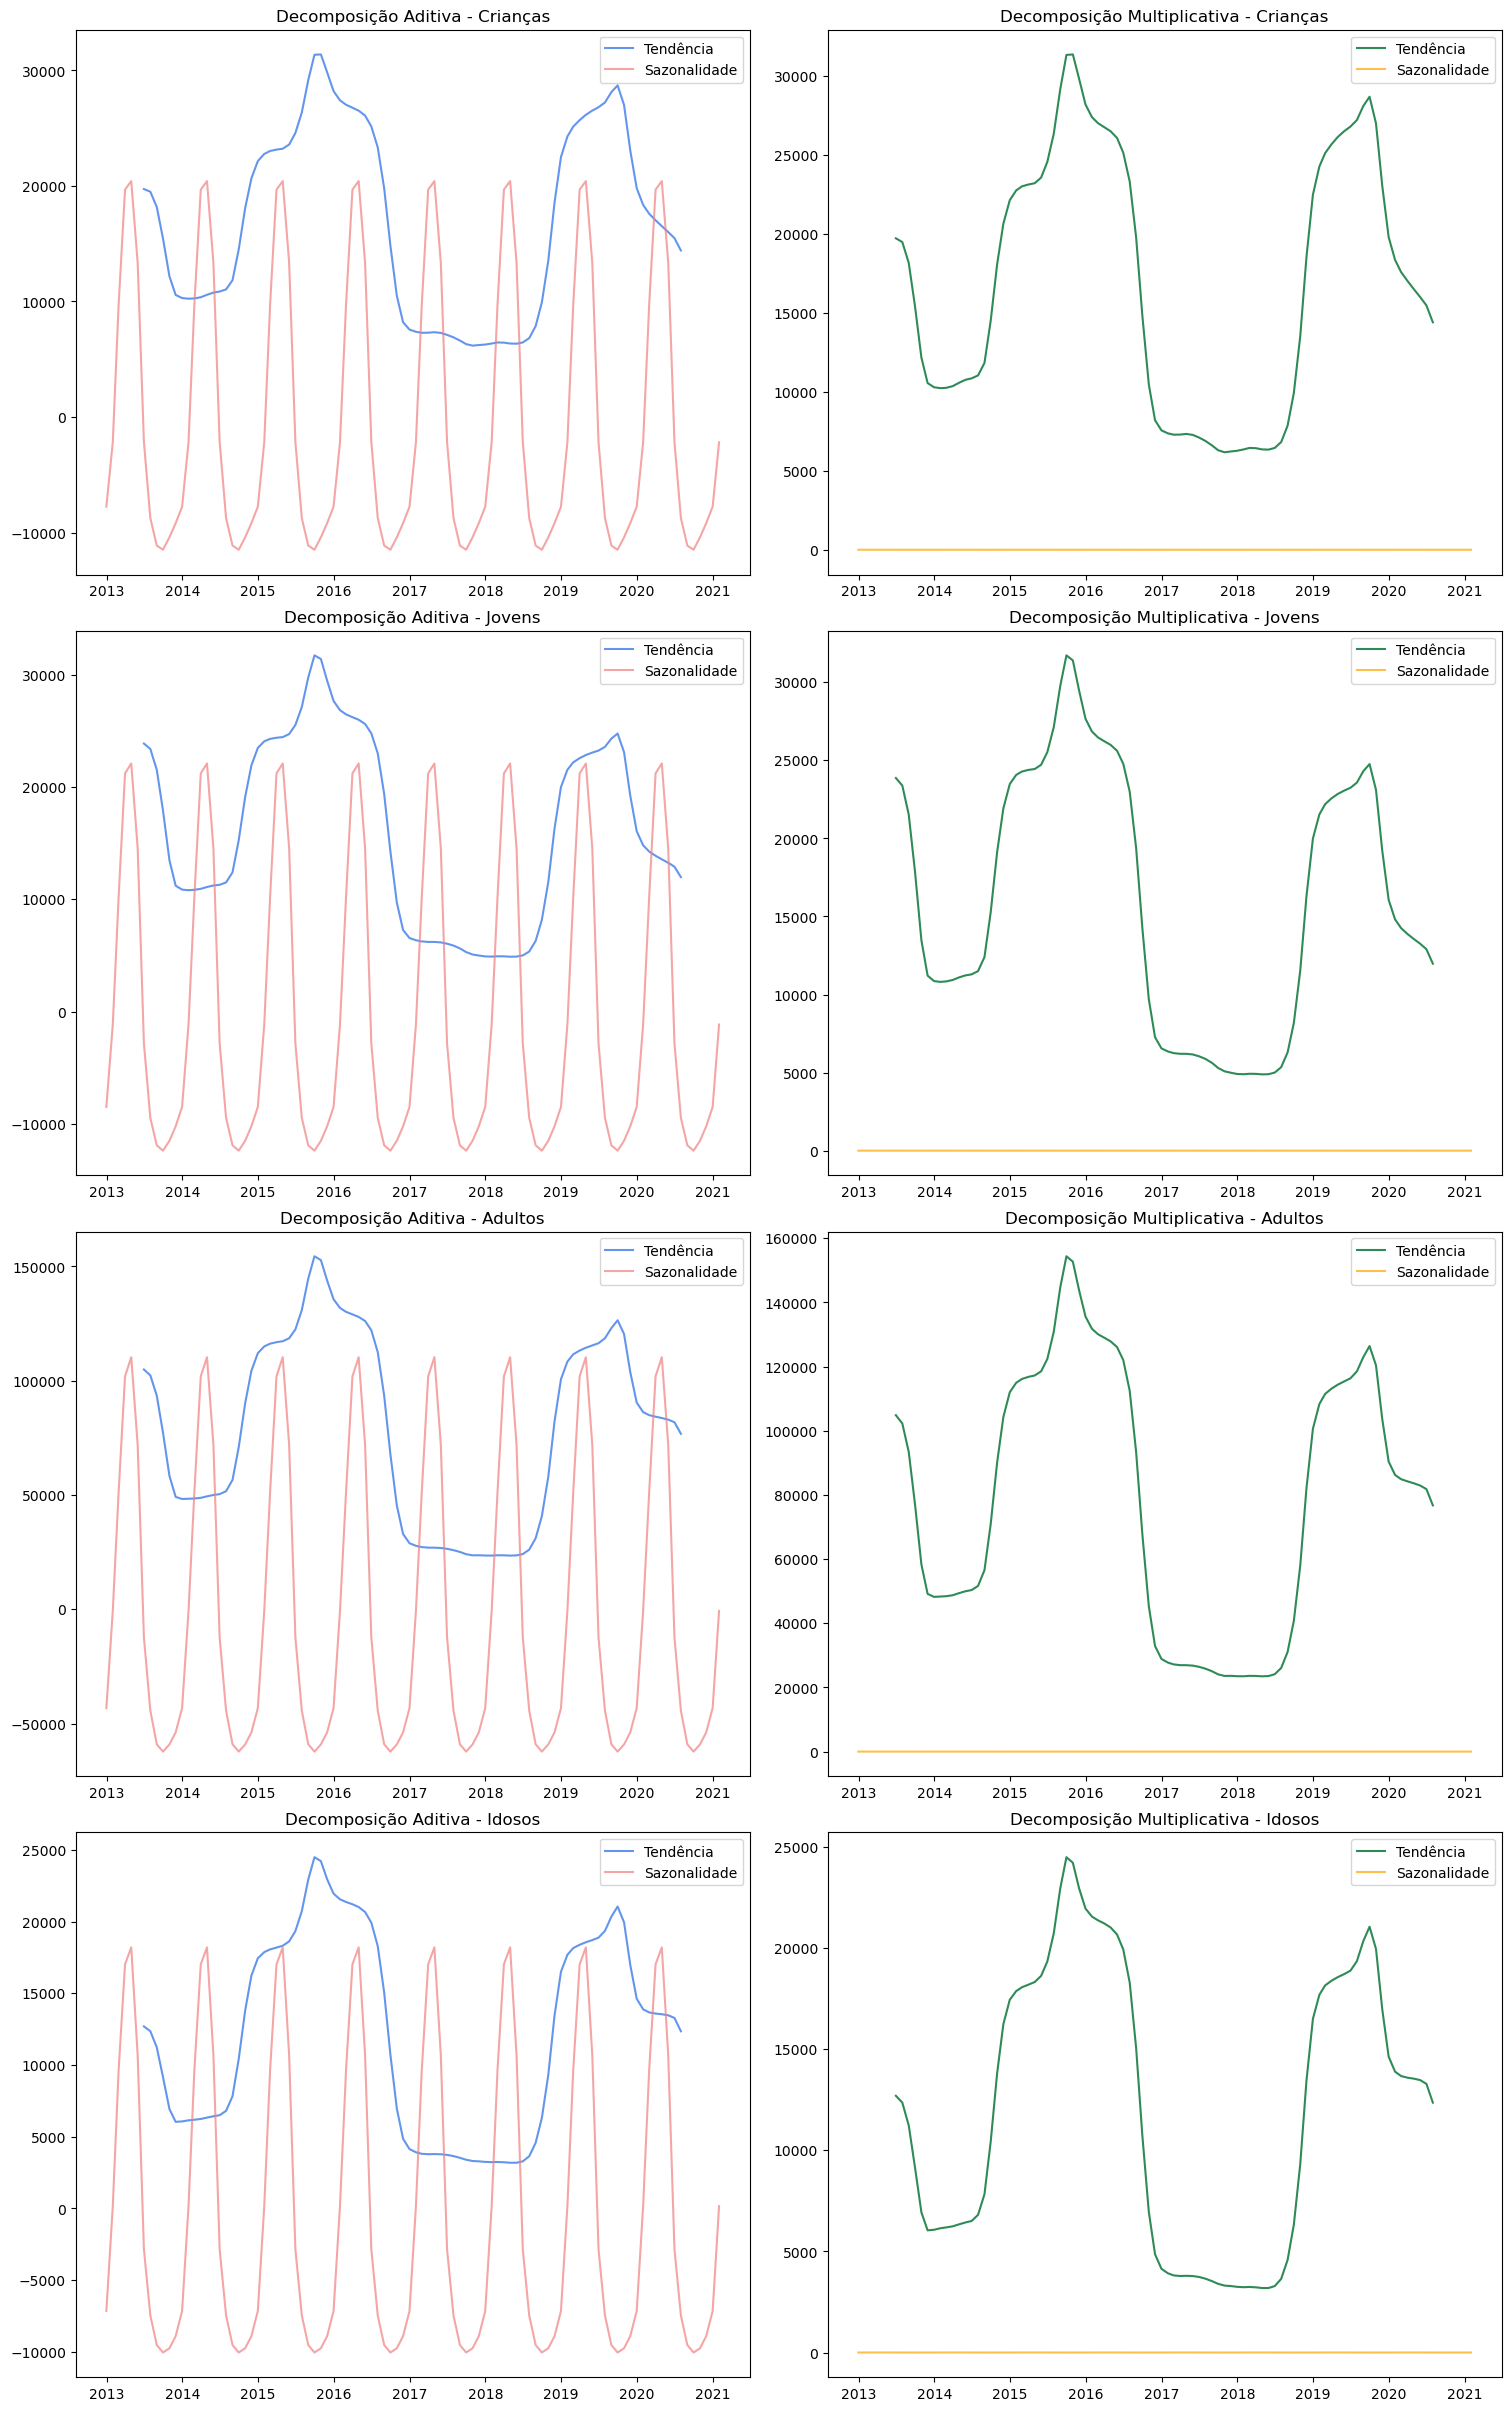

In [36]:
plot_time_series_decomposition(data=registers, column_name='grupo_idade')

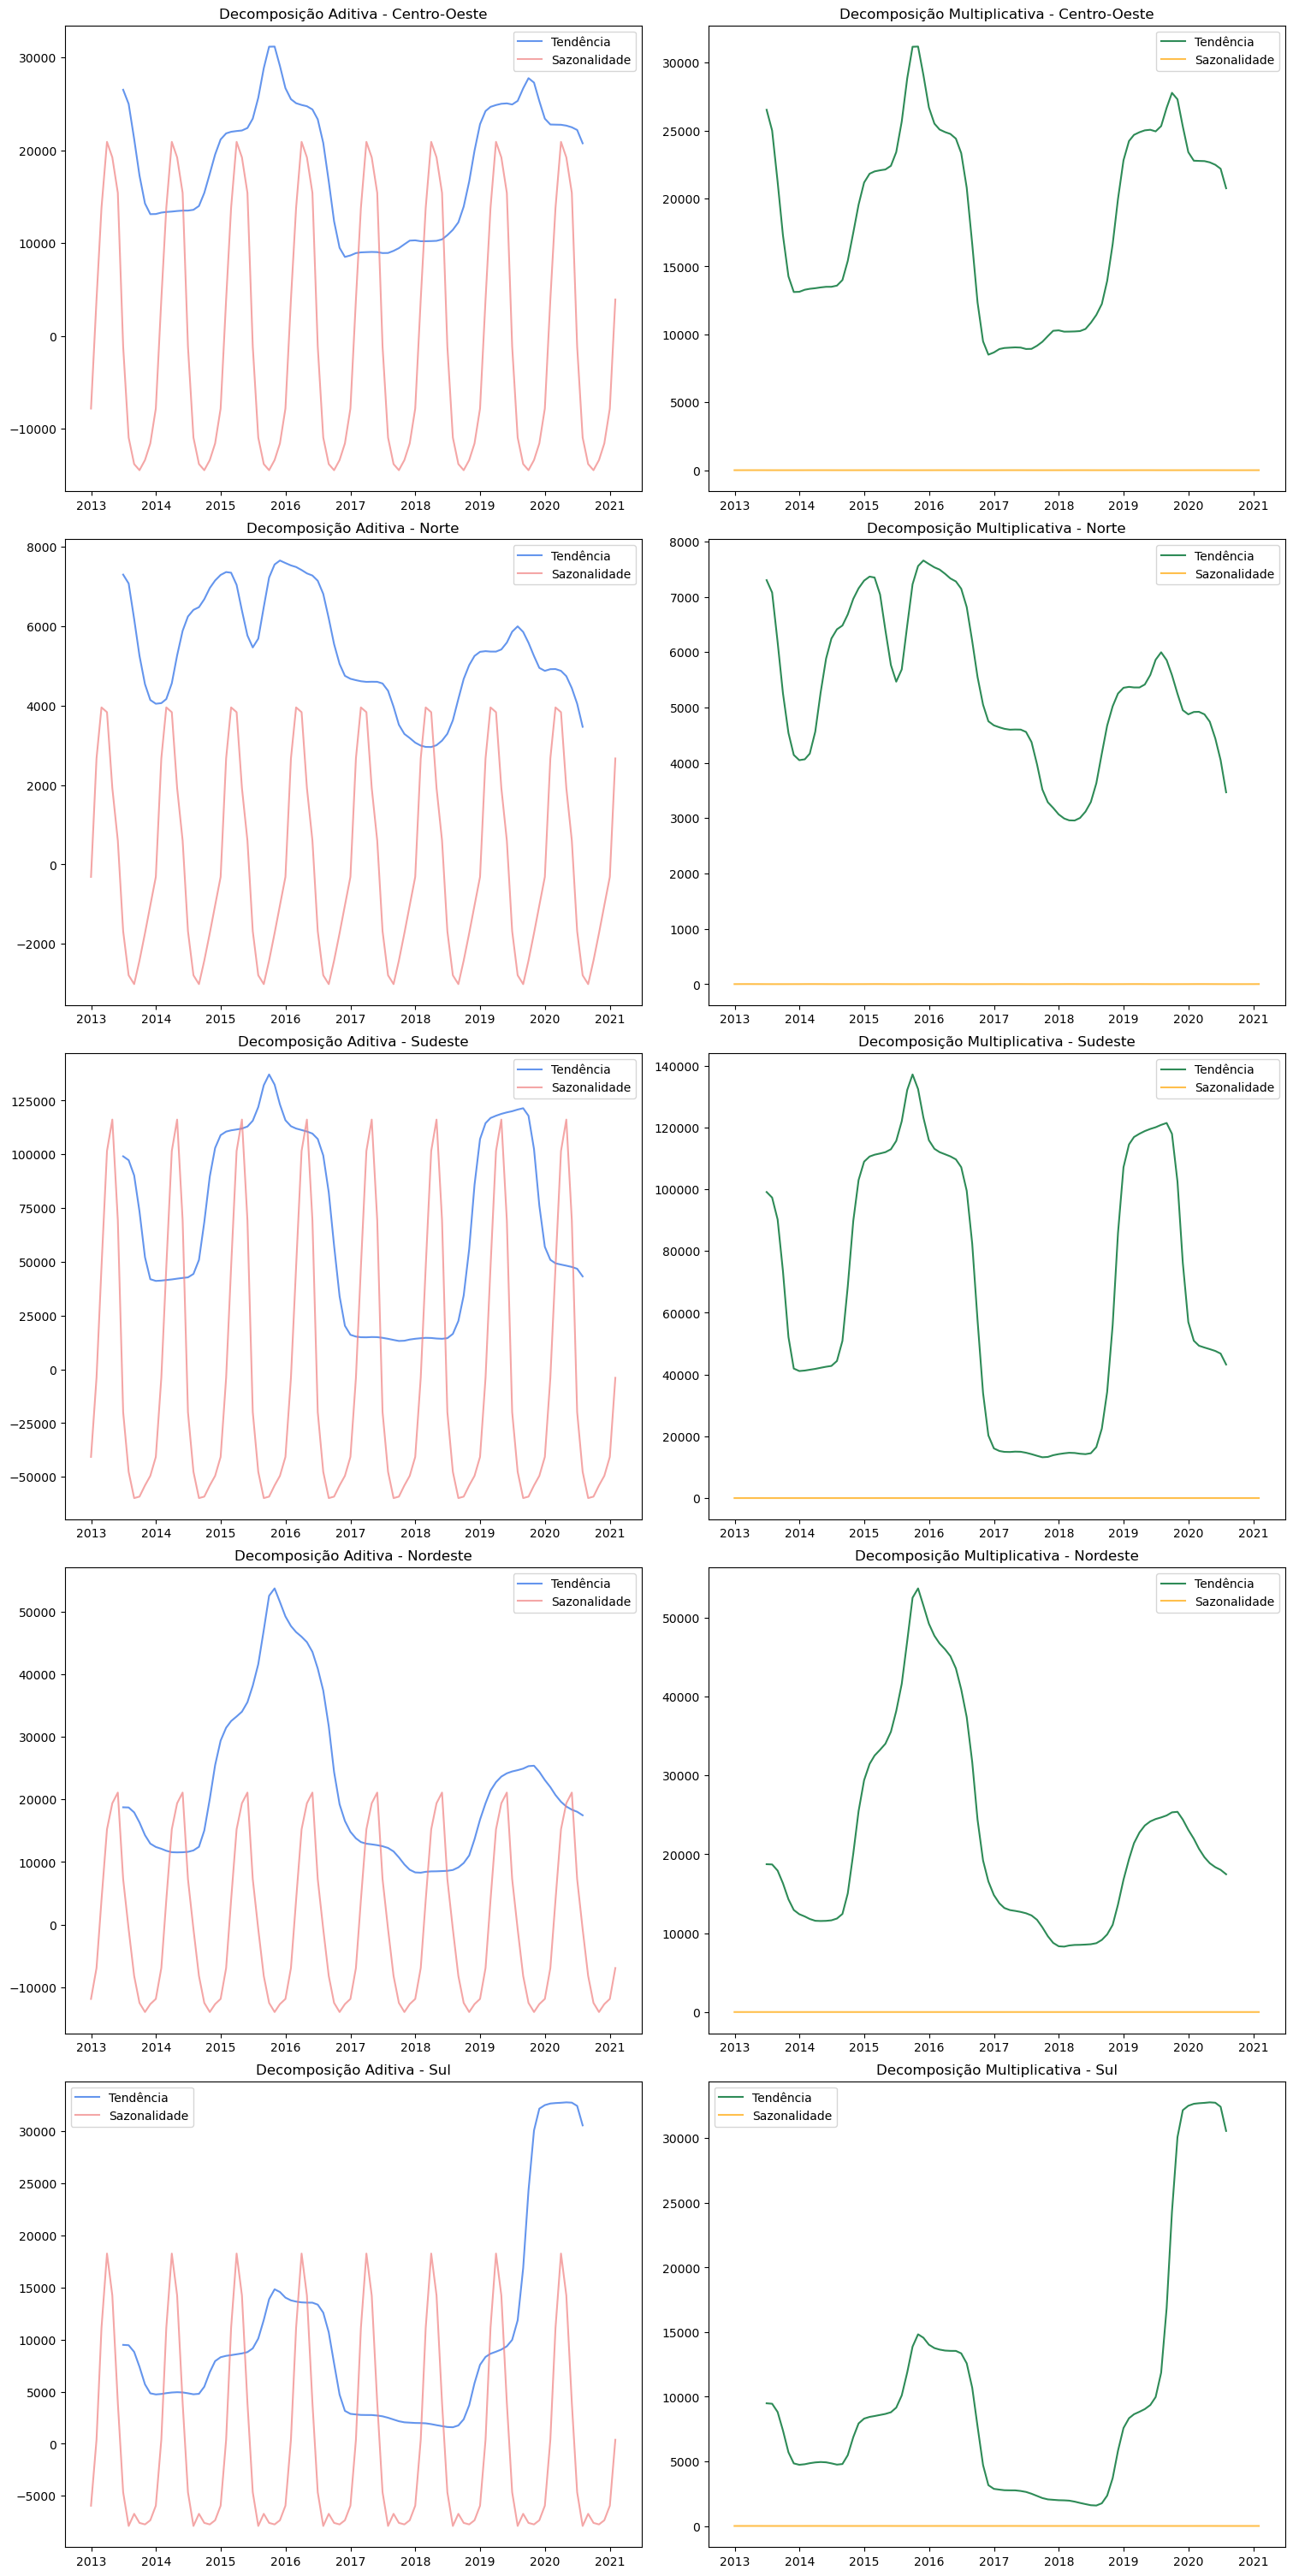

In [37]:
plot_time_series_decomposition(data=registers, column_name='regiao')

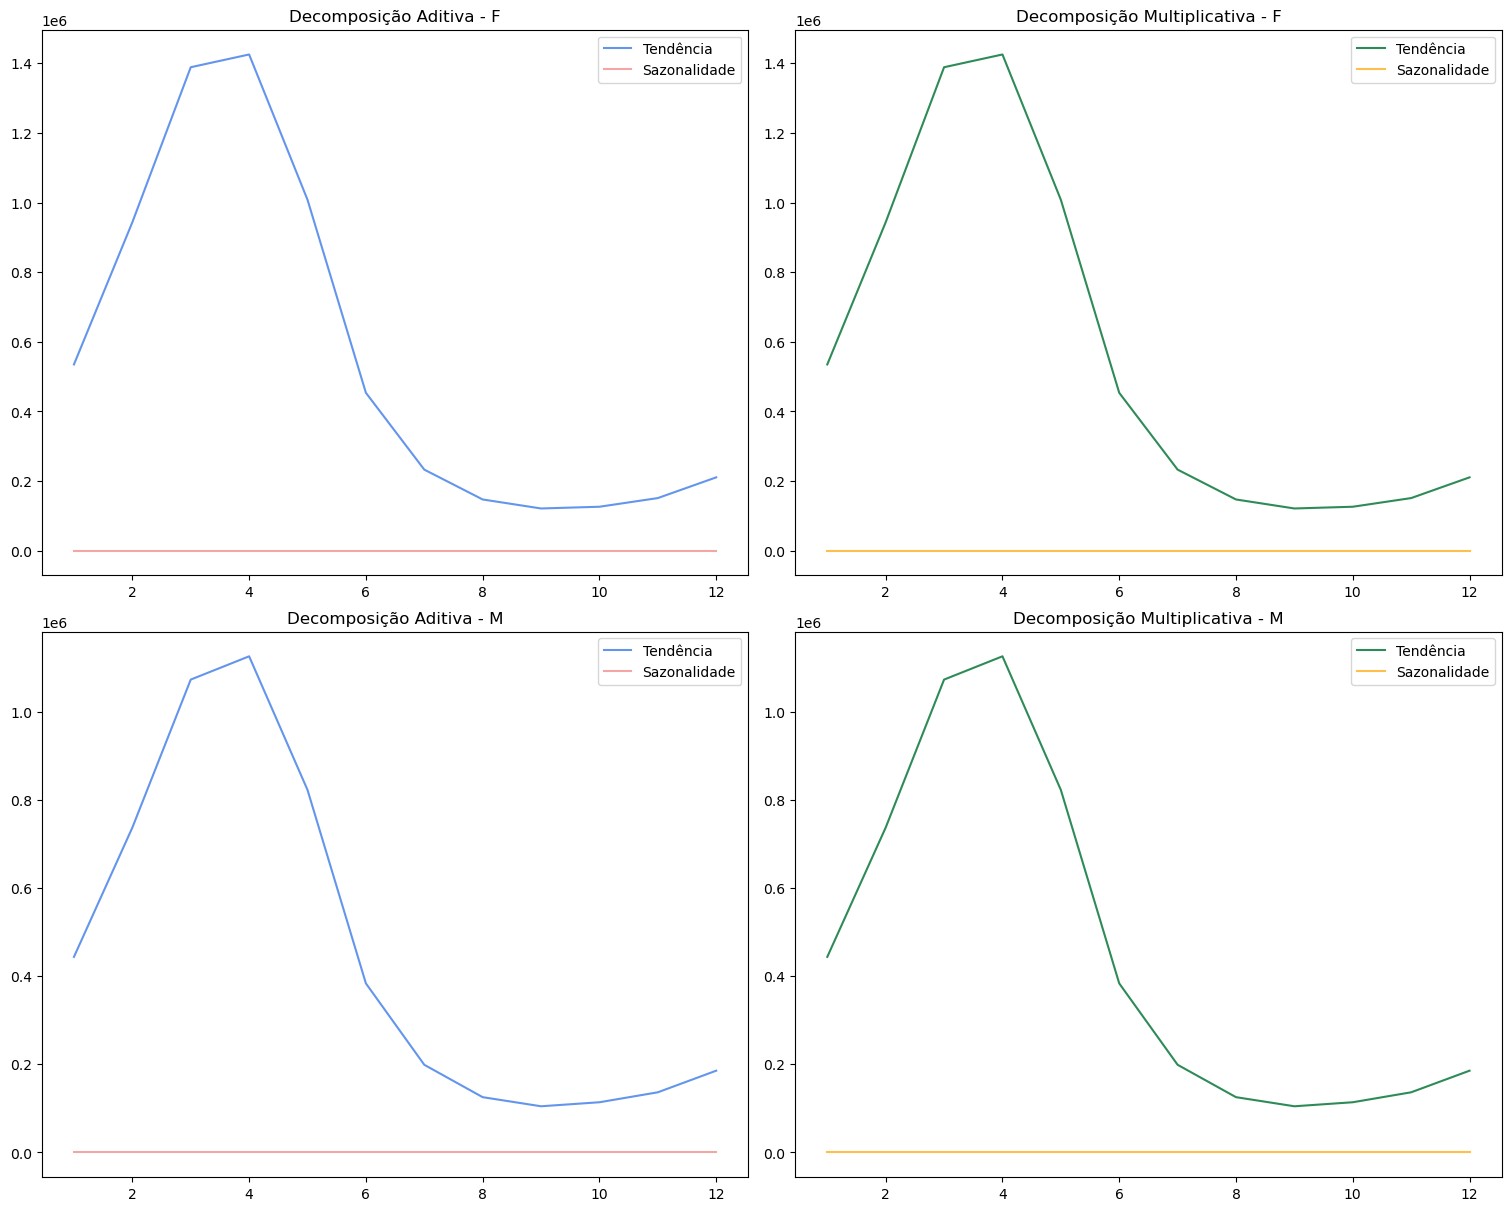

In [38]:
def plot_monthly_decomposition(data: pd.DataFrame, column_name: str, month_column: str, period: int = 1) -> None:
    
    """
    Plota a decomposição aditiva e multiplicativa das séries temporais mensais para cada valor único da coluna escolhida.
    Os gráficos são exibidos em subplots com a decomposição aditiva na coluna esquerda e multiplicativa na direita.

    Parâmetros:
        data (pd.DataFrame): O DataFrame com os registros.
        column_name (str): O nome da coluna para agrupar e plotar os dados ('genero', 'grupo_idade', 'regiao').
        month_column (str): O nome da coluna que contém o mês para a decomposição.
        period (int): O período da sazonalidade para a decomposição, que é 1 por padrão para séries mensais.

    """
    
    data = data.replace('Não Identificado', np.nan).dropna()
    
    if column_name not in ['genero', 'grupo_idade', 'regiao']:
        raise ValueError(f"A coluna escolhida deve ser 'genero', 'grupo_idade' ou 'regiao'.")

    unique_values = data[column_name].unique()
    
    n_rows = len(unique_values)
    fig, axs = plt.subplots(n_rows, 2, figsize=(15, n_rows * 6), constrained_layout=True)
    
    if n_rows == 1:
        axs = [axs]
        
    for i, value in enumerate(unique_values):
        subset_data = data[data[column_name] == value].copy()
        
        time_series = subset_data.groupby(month_column)['pacientes'].sum()
        
        time_series = time_series.fillna(0)
        
        decomposition_additive = seasonal_decompose(time_series, model='additive', period=period, extrapolate_trend='freq')
        decomposition_multiplicative = seasonal_decompose(time_series, model='multiplicative', period=period, extrapolate_trend='freq')
        
        axs[i, 0].plot(decomposition_additive.trend, label='Tendência', color='cornflowerblue')
        axs[i, 0].plot(decomposition_additive.seasonal, label='Sazonalidade', color='lightcoral', alpha=0.7)
        axs[i, 0].set_title(f'Decomposição Aditiva - {value}')
        axs[i, 0].legend()
        
        axs[i, 1].plot(decomposition_multiplicative.trend, label='Tendência', color='seagreen')
        axs[i, 1].plot(decomposition_multiplicative.seasonal, label='Sazonalidade', color='orange', alpha=0.7)
        axs[i, 1].set_title(f'Decomposição Multiplicativa - {value}')
        axs[i, 1].legend()
    
    plt.show()
    
    
plot_monthly_decomposition(data=registers, column_name='genero', month_column='mes')

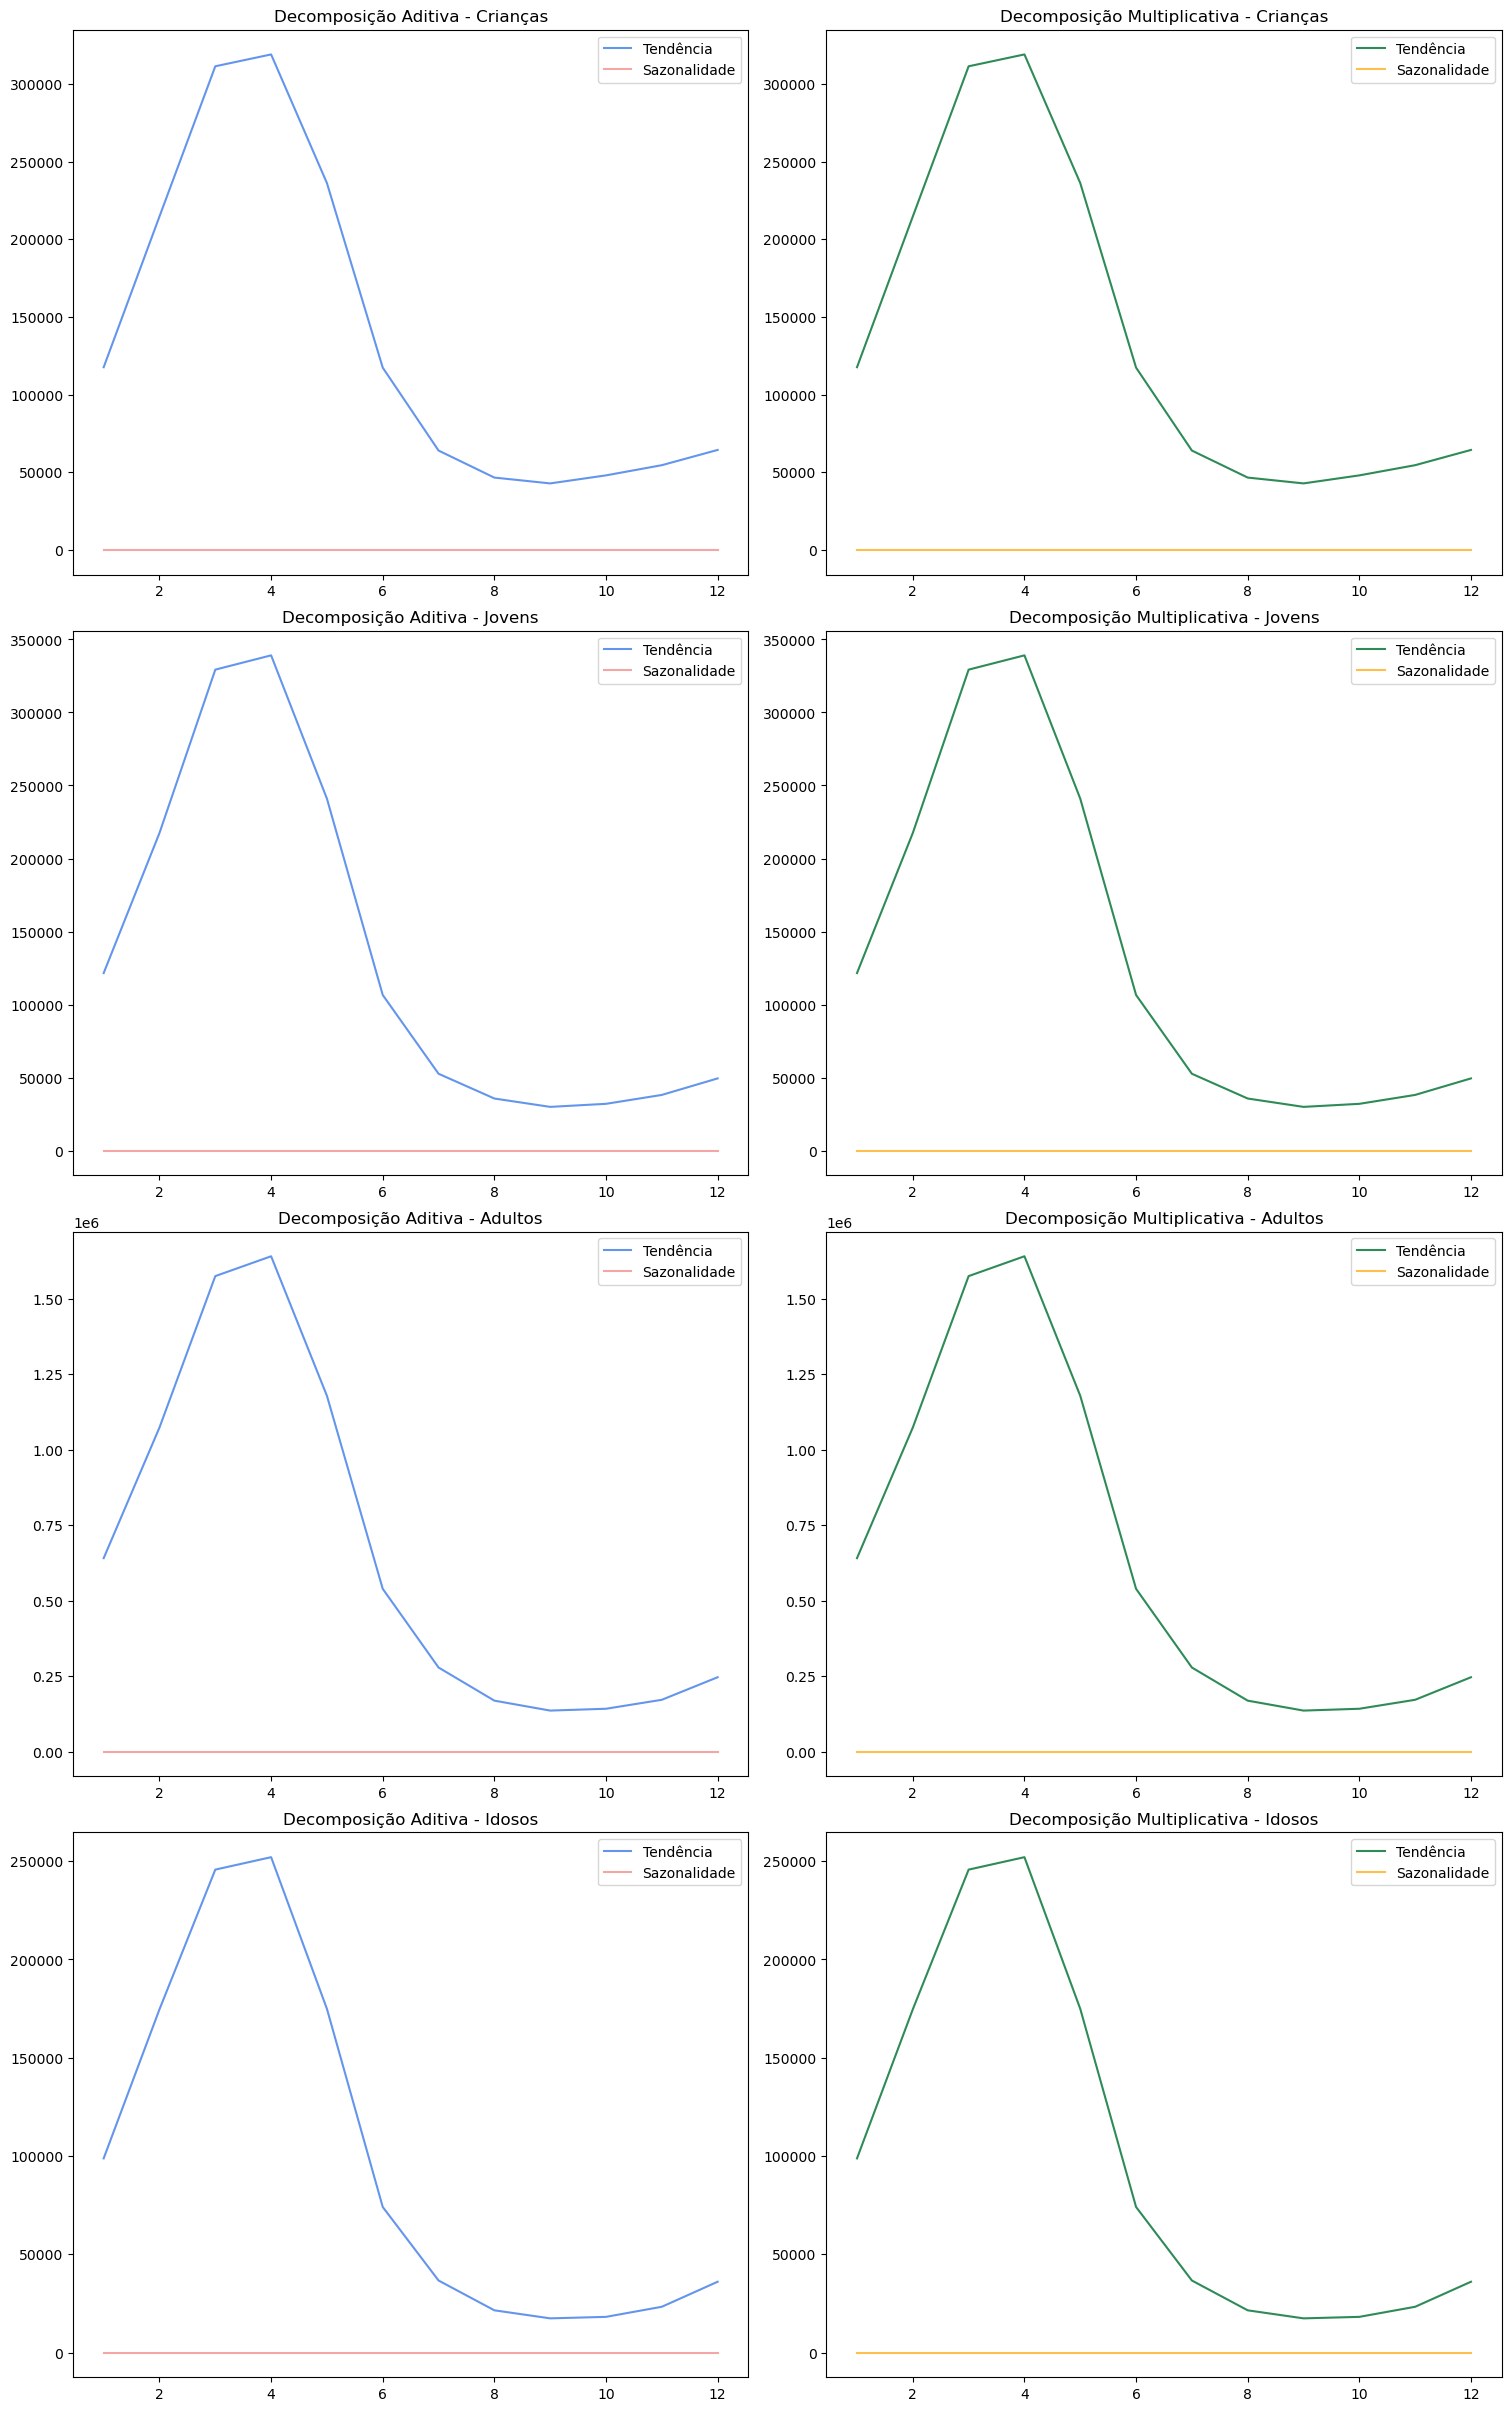

In [39]:
plot_monthly_decomposition(data=registers, column_name='grupo_idade', month_column='mes')

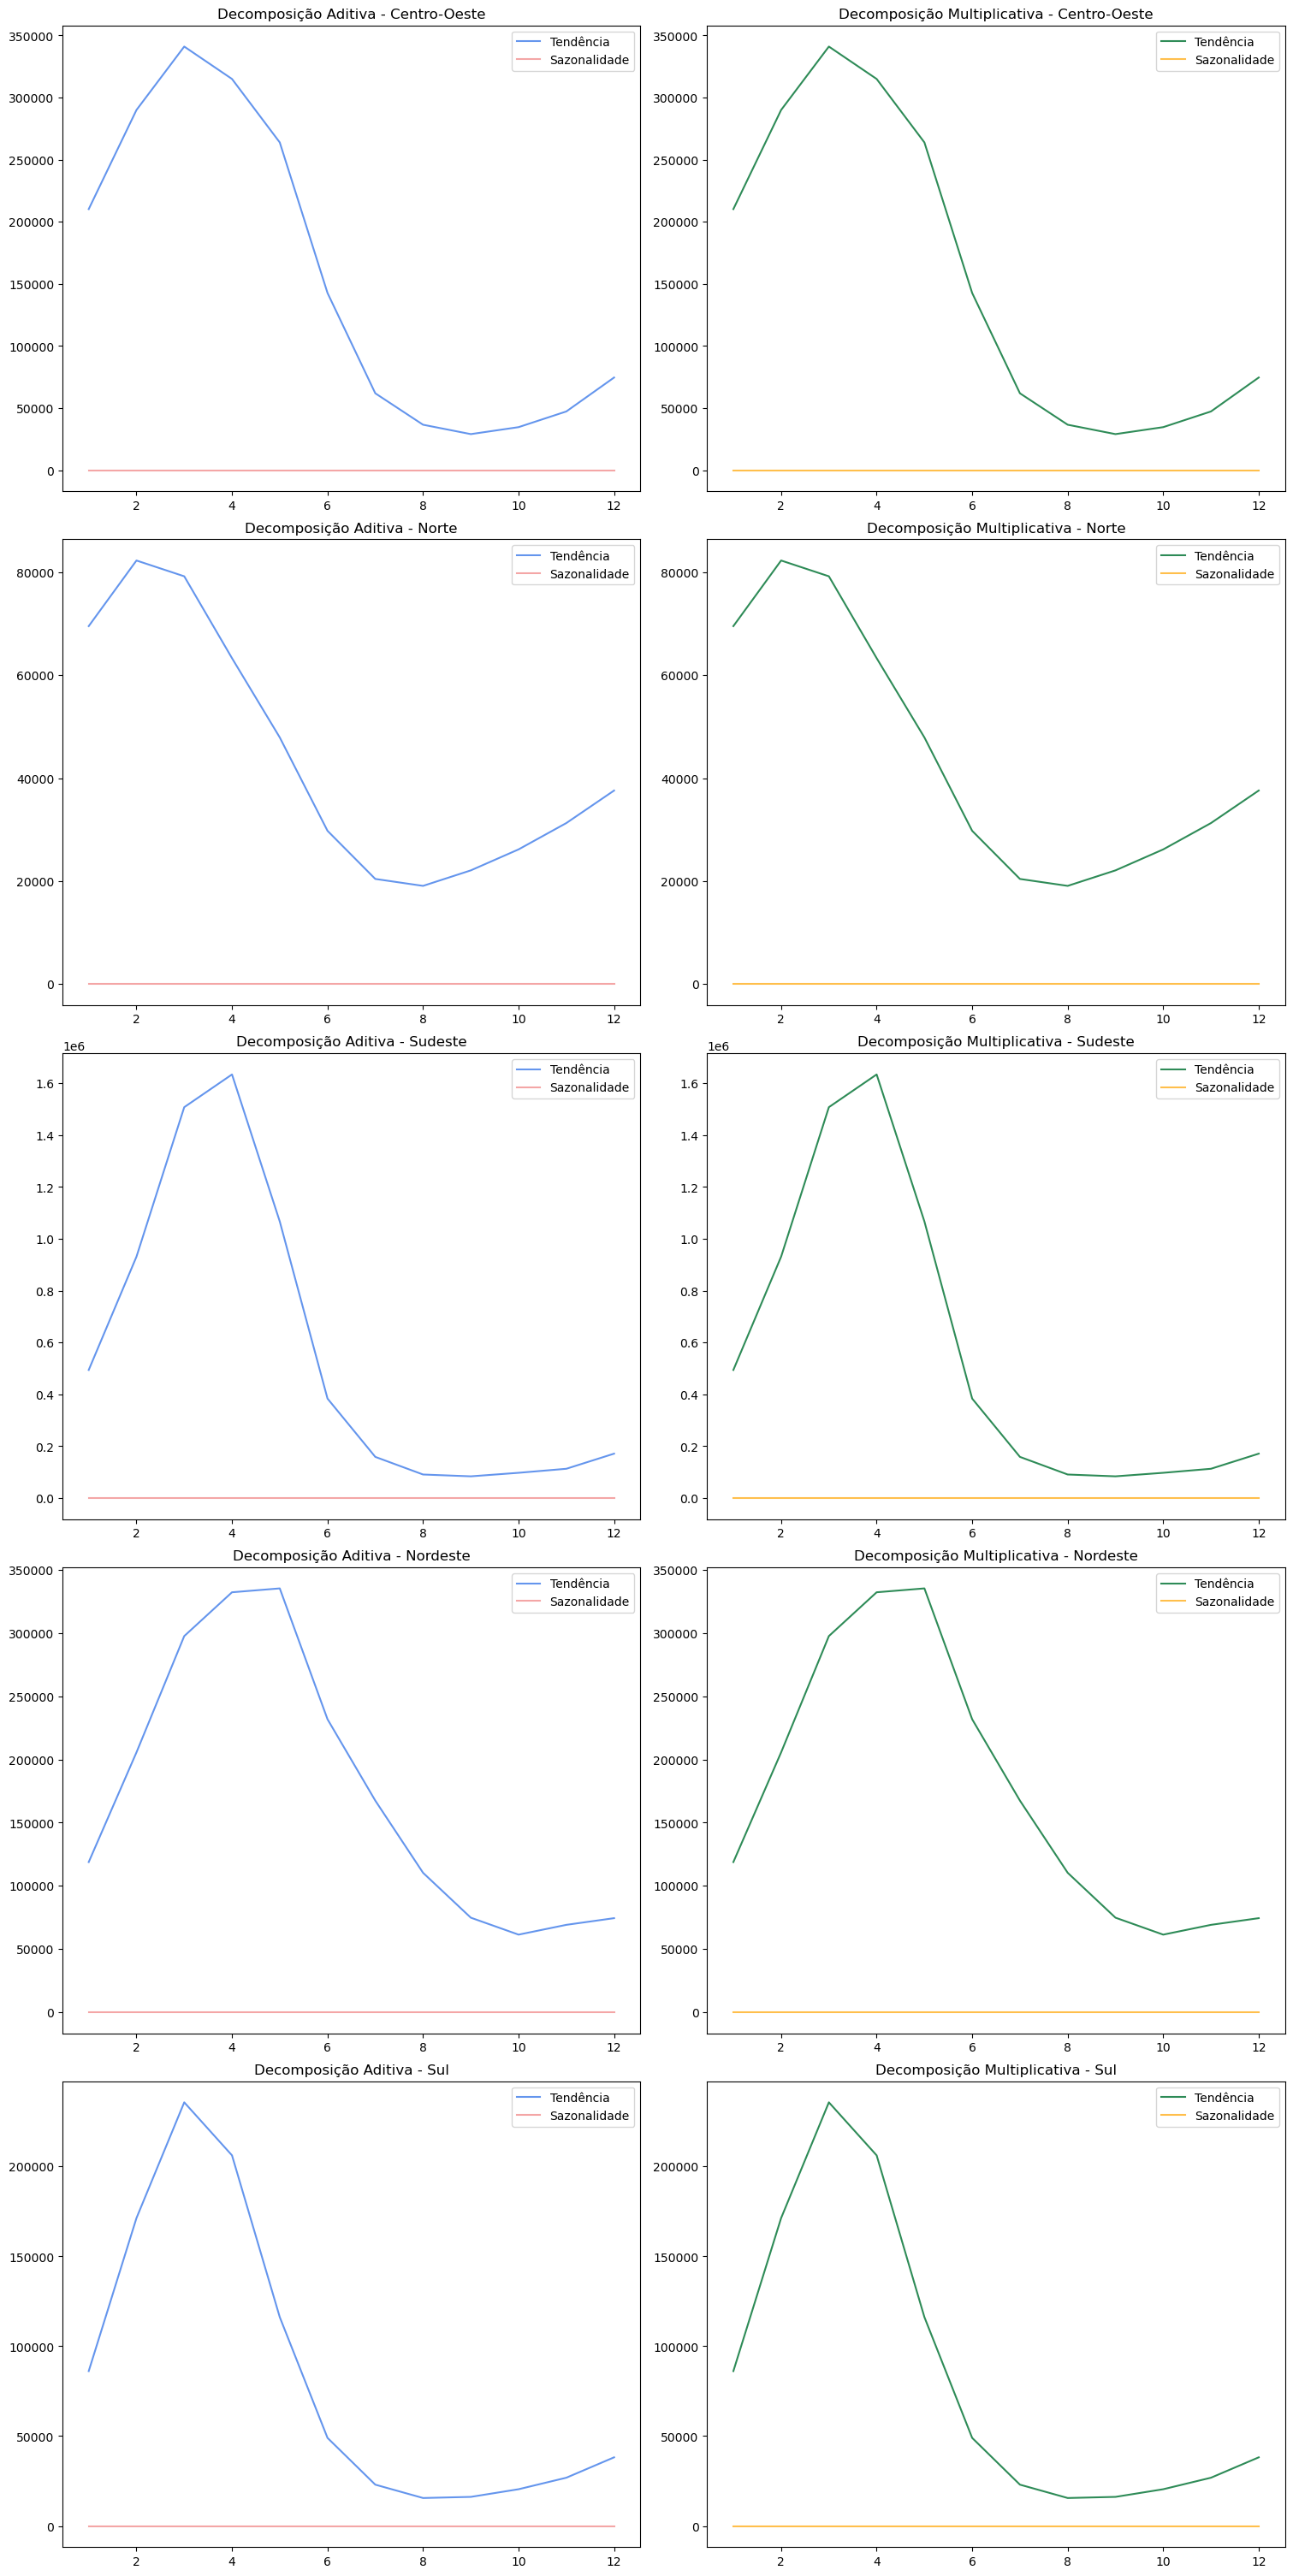

In [40]:
plot_monthly_decomposition(data=registers, column_name='regiao', month_column='mes')

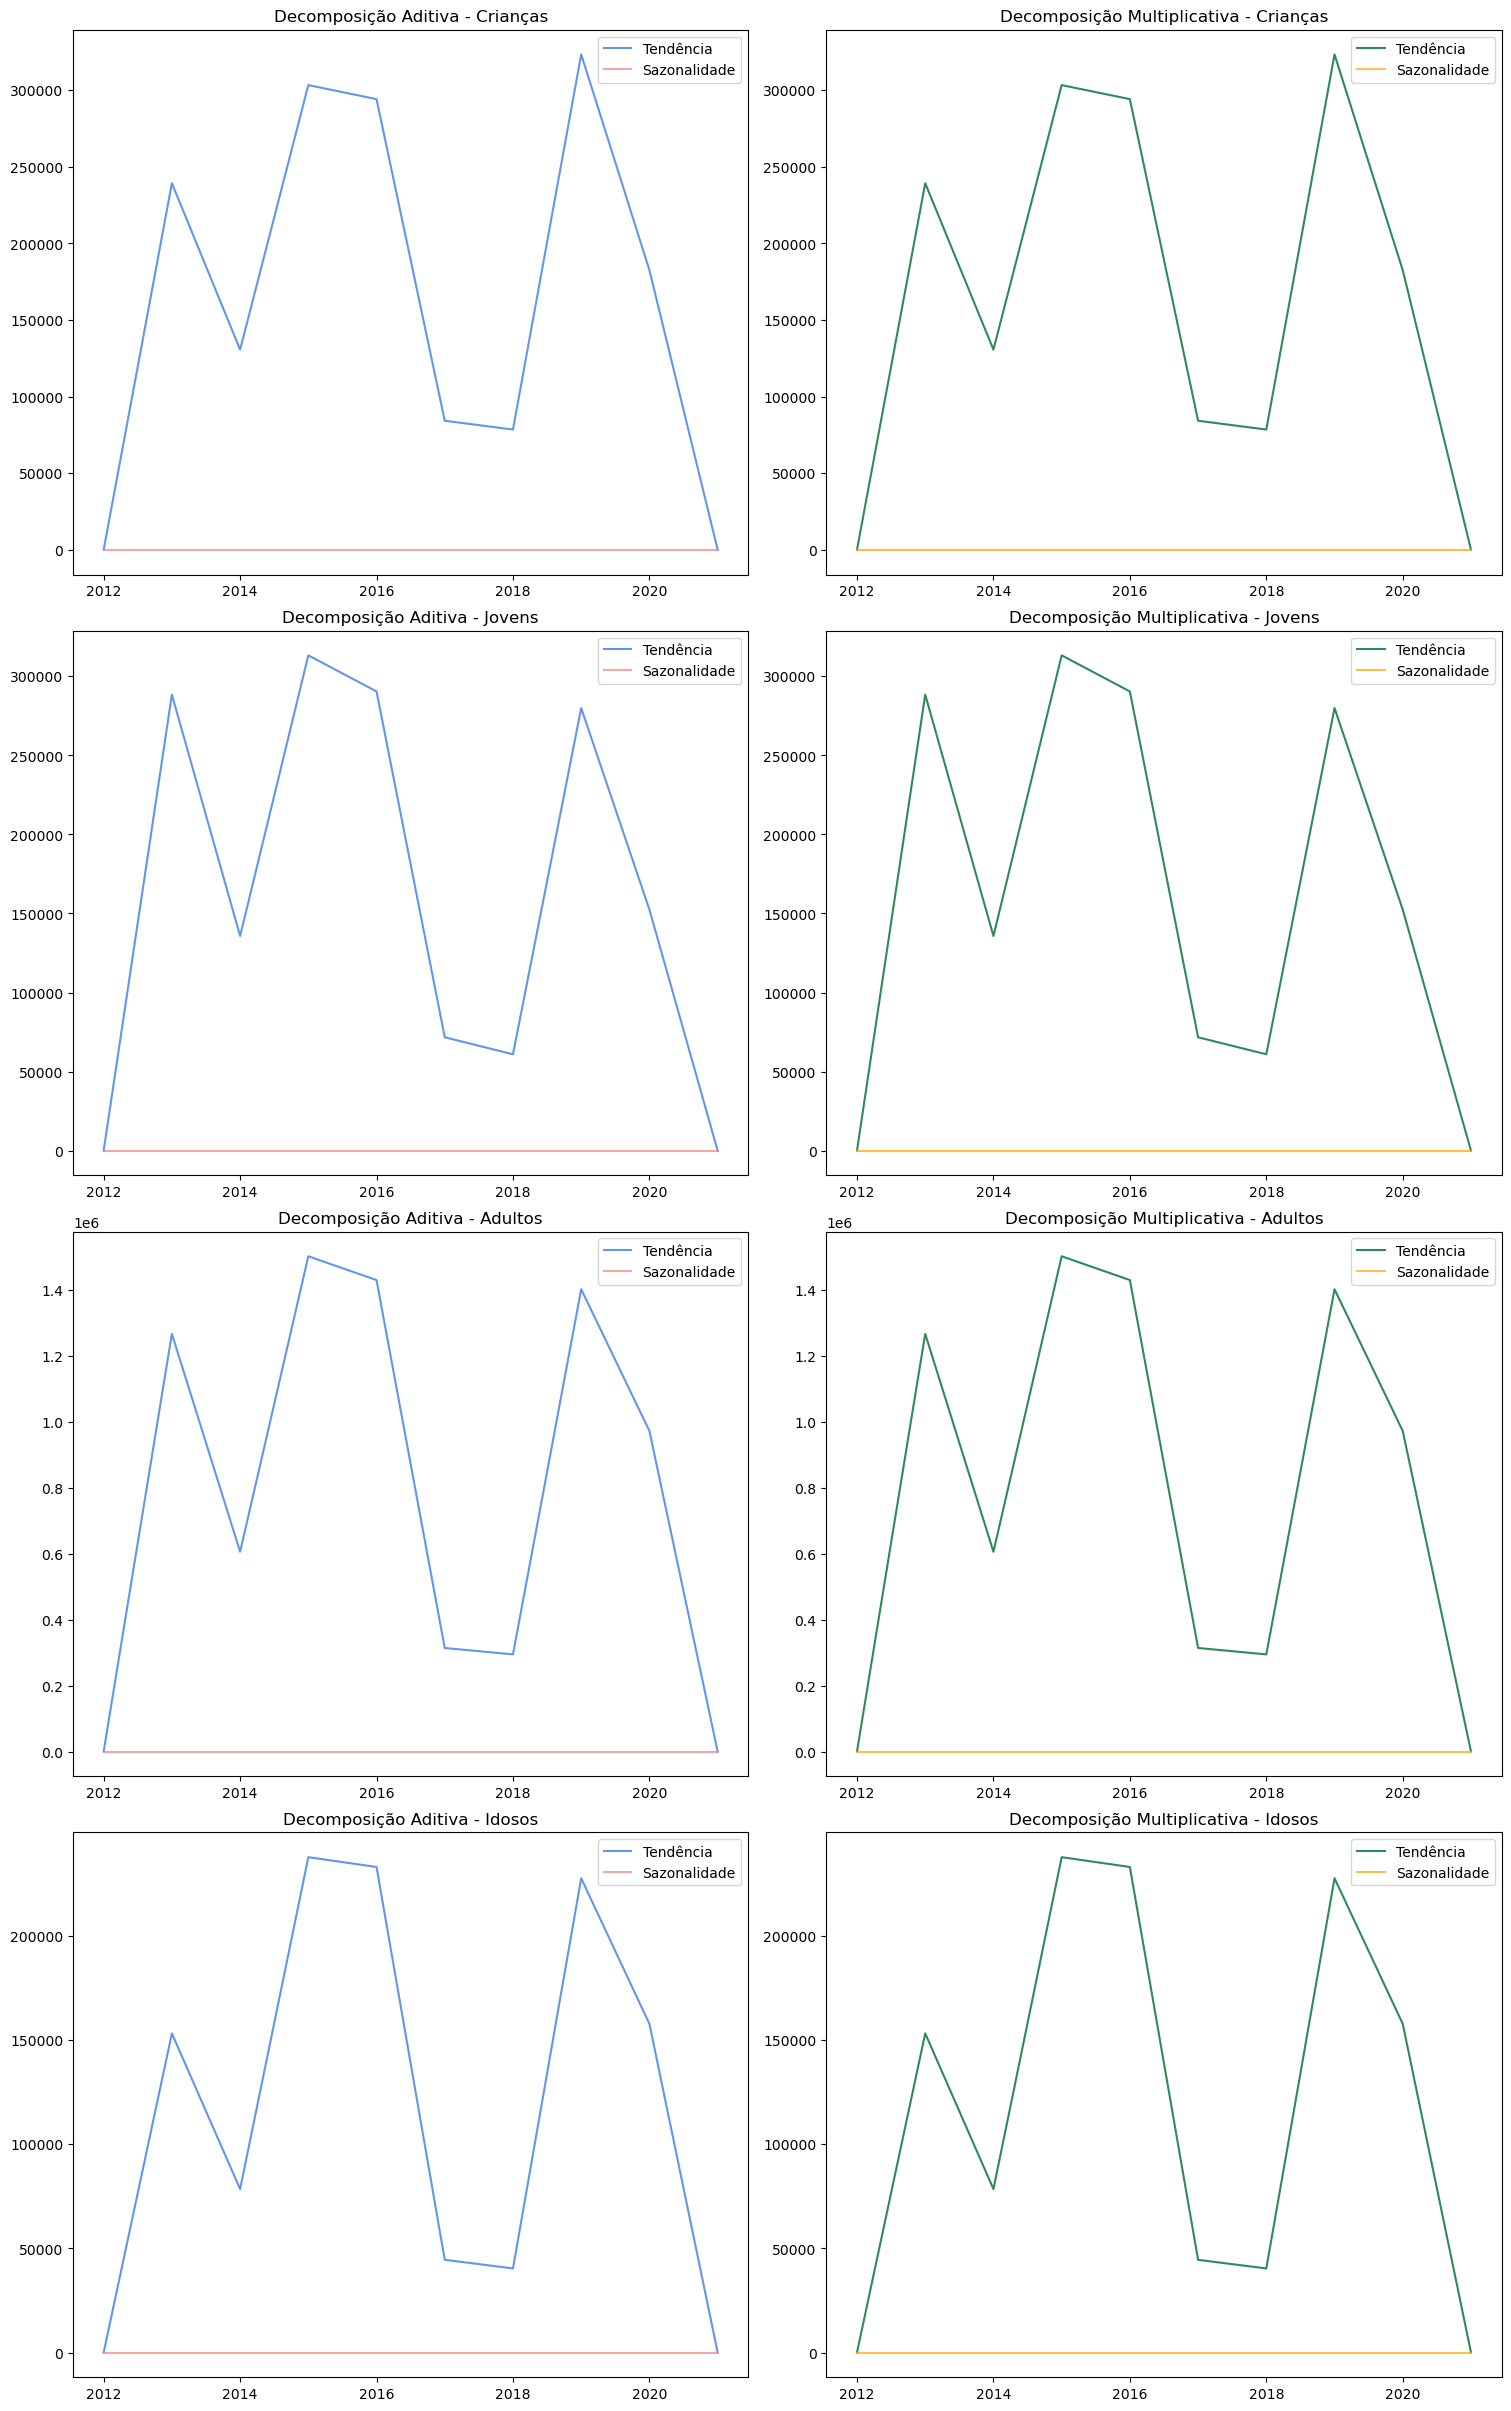

In [41]:
plot_monthly_decomposition(data=registers, column_name='grupo_idade', month_column='ano')

In [41]:
registers_series = registers.set_index('mes_ano')
series = registers_series['pacientes']

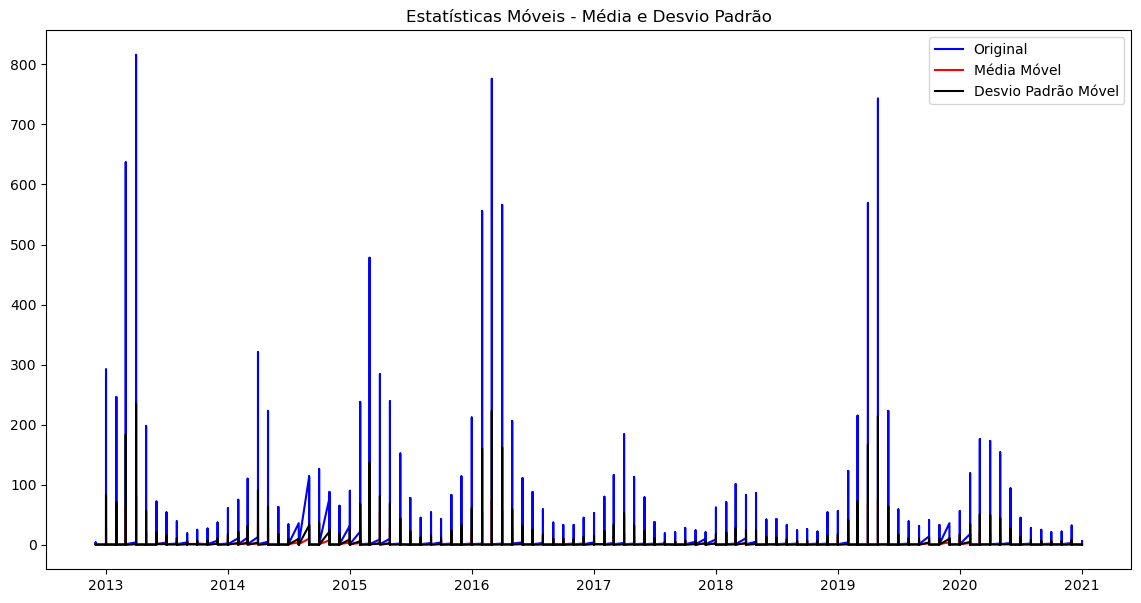


Resultado do Teste Dickey-Fuller:



In [ ]:
def testa_estacionaridade(serie, window=12):
    
    if not isinstance(serie.index, pd.DatetimeIndex):
        serie.index = pd.to_datetime(serie.index)

    rolmean = serie.rolling(window=window).mean()
    rolstd = serie.rolling(window=window).std()

    plt.figure(figsize=(14, 7))
    orig = plt.plot(serie, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Média Móvel')
    std = plt.plot(rolstd, color='black', label='Desvio Padrão Móvel')
    plt.legend(loc='best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show(block=False)
    
    # dick fuller
    print('\nResultado do Teste Dickey-Fuller:\n')
    dfteste = adfuller(serie, autolag='AIC')
    dfsaida = pd.Series(dfteste[0:4], index=['Estatística do Teste',
                                             'Valor-p',
                                             'Número de Lags Consideradas',
                                             'Número de Observações Usadas'])
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' % key] = value
    print(dfsaida)
    
    # pvalue
    print('\nConclusão:')
    if dfsaida['Valor-p'] > 0.05:
        print('O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

        
testa_estacionaridade(series)

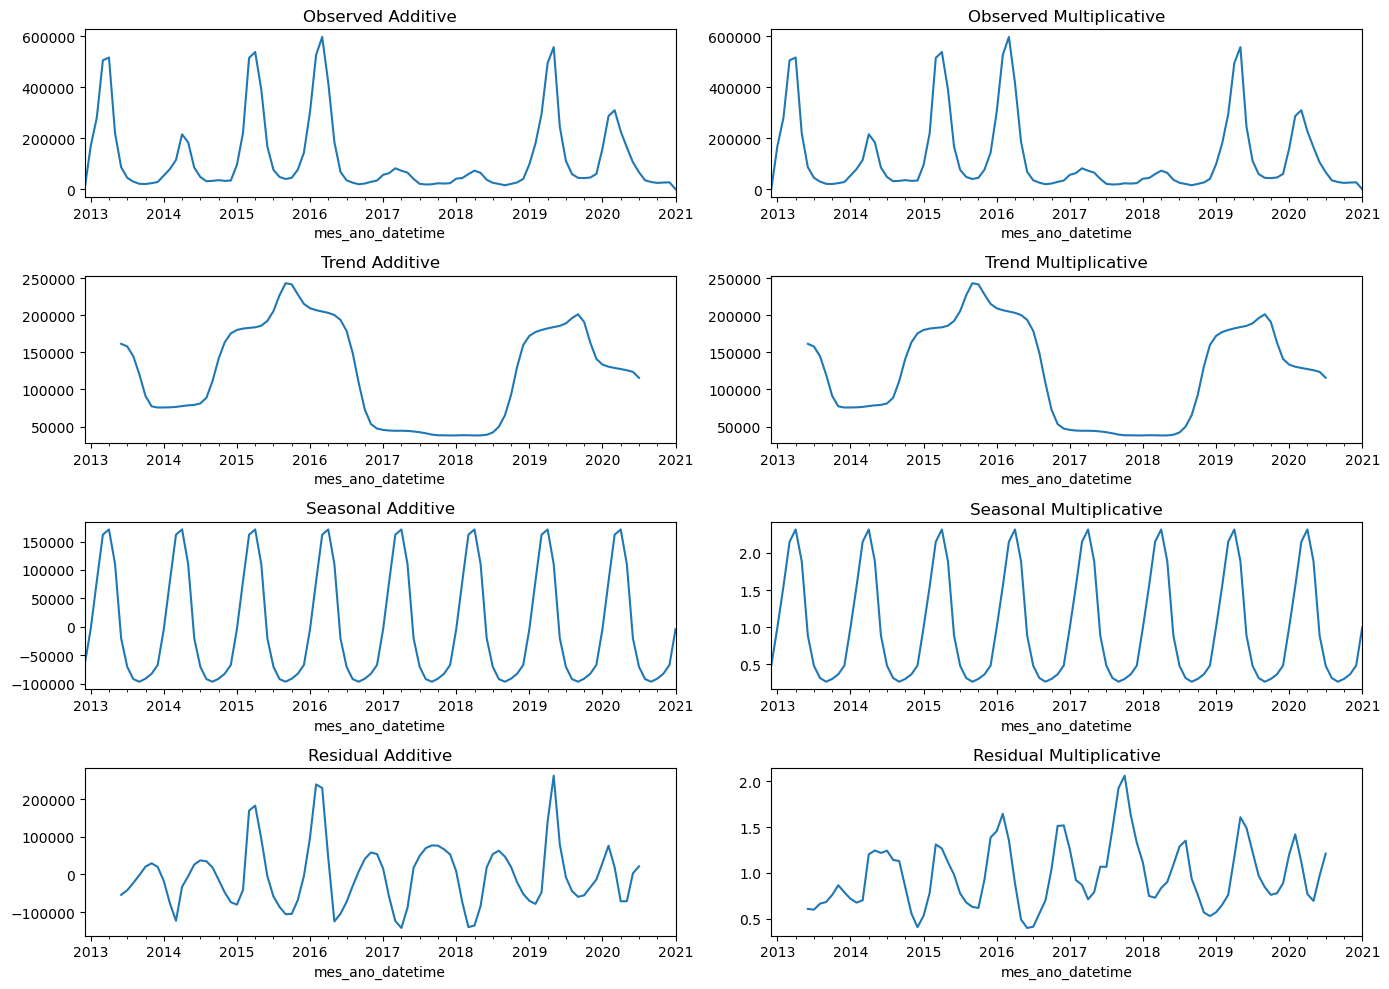

In [42]:
def plot_seasonal_decompositions(data: pd.DataFrame, date_col: str, data_col: str):
    
    """
    Performs seasonal decomposition on a time series data and plots the additive and 
    multiplicative decompositions side by side for each component: observed series, trend, 
    seasonality, and residuals.
  
    """
    
    data[date_col] = pd.to_datetime(data[date_col])
    data.set_index(date_col, inplace=True)

    grouped_data = data.groupby(data.index).agg({data_col: 'sum'})

    decomposicao_aditiva = sm.tsa.seasonal_decompose(grouped_data, model='additive')
    decomposicao_multiplicativa = sm.tsa.seasonal_decompose(grouped_data, model='multiplicative')

    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 10))

    decomposicao_aditiva.observed.plot(ax=axs[0, 0], title='Observed Additive')
    decomposicao_aditiva.trend.plot(ax=axs[1, 0], title='Trend Additive')
    decomposicao_aditiva.seasonal.plot(ax=axs[2, 0], title='Seasonal Additive')
    decomposicao_aditiva.resid.plot(ax=axs[3, 0], title='Residual Additive')

    decomposicao_multiplicativa.observed.plot(ax=axs[0, 1], title='Observed Multiplicative')
    decomposicao_multiplicativa.trend.plot(ax=axs[1, 1], title='Trend Multiplicative')
    decomposicao_multiplicativa.seasonal.plot(ax=axs[2, 1], title='Seasonal Multiplicative')
    decomposicao_multiplicativa.resid.plot(ax=axs[3, 1], title='Residual Multiplicative')

    plt.tight_layout()
    plt.show()

    return decomposicao_aditiva, decomposicao_multiplicativa

results = plot_seasonal_decompositions(registers_series, 'mes_ano_datetime', 'pacientes')